# Laboratory 2
Вариант 1 (дедлайн 10.10) - 10 баллов

Задача классификации цветов автомобилей.
Датасет DVM: https://deepvisualmarketing.github.io/
Ход работы:
1. Написать своими руками классификатор любой на выбор: ResNet, InceptionV3, DenseNet, MobileNet, ShuffleNet и обучить его на полученном датасете.
2. Также взять аналогичный классификатор, но предобученный на ImageNet или на Cityscapes и дообучить на собранном датасете. Выяснить, чей классификатор лучше.

Оценка качества производится при помощи F1_macro, требуется получить F1_macro > 0.8. Сравнить полученное качество и сделать вывод.

# Imports

In [1]:
import requests
import shutil 
import pandas as pd
import os 
from tqdm import tqdm
import random
import pathlib

import torchvision
# from torchvision.transforms import v2 as T
from torchvision import transforms as T
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image

from torch.utils.data import DataLoader, Dataset

import torch
import torch.nn as nn
from torch import Tensor

from typing import Optional, Callable, Union, Type, Union, List

In [2]:
seed = 42

torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

# Loading DVM dataset

In [3]:
url = 'https://figshare.com/ndownloader/files/34792480'
response = requests.get(url, stream=True)

path = "cars.zip"
with open(path, 'wb') as out_file:
    shutil.copyfileobj(response.raw, out_file)

In [4]:
!unzip -q -o cars.zip

In [5]:
from PIL import Image, ImageFile
from tqdm import tqdm

ImageFile.LOAD_TRUNCATED_IMAGES = True

def validate_images(folder_path):
    count_size = {}
    file_count = sum(len(files) for _, _, files in os.walk(folder_path))
    with tqdm(total=file_count) as pbar:
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                pbar.update(1)
                
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):    
                    image_path = os.path.join(root, file)
                
                    try:
                        img = Image.open(image_path)
                        count_size[img.size] = count_size.get(img.size, 0) + 1
                        img.load()
                        img.close()
                    except Exception as e:
                        print(f"Image is incorrect: {image_path}")
                        print(e)
                        os.remove(image_path)
    return count_size

In [6]:
validate_images('/kaggle/working/confirmed_fronts')

100%|██████████| 61827/61827 [00:49<00:00, 1254.64it/s]


{(300, 300): 61827}

# Prepare dataset

In [7]:
def split_dataset(dataset_root, test_ratio=0.05):
    out_train_fname = 'train.csv'
    out_test_fname = 'test.csv'
    print("Running splitting dataset to Train and Test")
    print(f"test_ratio: {test_ratio}")
    print(f"dataset_root: {dataset_root}")
    print(f"out_train_fname: {out_train_fname}")
    print(f"out_test_fname: {out_test_fname}")

    image_counter = {}
    
    classes = os.listdir(dataset_root)
    out_train_files = []
    out_test_files = []
    for i, cls in enumerate(tqdm(classes)):
        
        cur_dir = pathlib.Path(f'{dataset_root}/{cls}')
        
        if not cur_dir.is_dir():
            continue
            
        img_names = list(map(str, [item for item in cur_dir.rglob("*") 
                                   if item.is_file() 
                                   and str(item).lower().endswith(('.jpg', '.jpeg', '.png'))]))
        
        img_names = list(map(lambda it: '/'.join(it.split('/')[1:]), img_names))
        
        test_size = int(len(img_names) * test_ratio)
        test_files = random.sample(img_names, test_size)
        
        for img_name in img_names:
            p = f'{cls},{img_name}\n'
            if img_name in test_files:
                out_test_files.append(p)
            else:
                out_train_files.append(p)
                
        image_counter[cls] = len(img_names)
                
    with open(f'{dataset_root}/{out_train_fname}', 'w') as f:
        f.writelines(out_train_files)
    print(f'Number of train images: {len(out_train_files)}')
    with open(f'{dataset_root}/{out_test_fname}', 'w') as f:
        f.writelines(out_test_files)
    print(f'Number of test images: {len(out_test_files)}')
    return len(classes), image_counter

In [8]:
dataset_root = './confirmed_fronts'
num_classes, image_counter = split_dataset(dataset_root, 0.1)
print(f"{num_classes=}\n{image_counter=}\n{len(image_counter)=}")

Running splitting dataset to Train and Test
test_ratio: 0.1
dataset_root: ./confirmed_fronts
out_train_fname: train.csv
out_test_fname: test.csv


100%|██████████| 63/63 [00:01<00:00, 31.67it/s]

Number of train images: 55669
Number of test images: 6158
num_classes=63
image_counter={'Nissan': 2667, 'Rolls-Royce': 31, 'Opel': 2, 'Abarth': 130, 'Mitsubishi': 595, 'Jaguar': 3240, 'MEV': 1, 'SKODA': 376, 'Smart': 52, 'Vauxhall': 1452, 'Infiniti': 171, 'Land Rover': 1677, 'Chevrolet': 364, 'Isuzu': 62, 'Ferrari': 109, 'Perodua': 2, 'Tesla': 59, 'Honda': 1303, 'Ford': 5260, 'SEAT': 239, 'Zenos': 1, 'Mazda': 1062, 'DS': 11, 'Citroen': 3565, 'Mercedes-Benz': 2176, 'Chrysler': 142, 'MINI': 320, 'Alfa Romeo': 533, 'Daihatsu': 41, 'Volvo': 1369, 'Renault': 396, 'Suzuki': 236, 'Peugeot': 875, 'Jeep': 675, 'Noble': 4, 'Lotus': 12, 'Lamborghini': 50, 'Hyundai': 896, 'Rover': 12, 'Subaru': 253, 'Bentley': 479, 'Lexus': 291, 'Porsche': 1833, 'Ssangyong': 96, 'Fiat': 2047, 'Audi': 10419, 'Great Wall': 10, 'Corvette': 4, 'Kia': 1872, 'Cadillac': 2, 'Volkswagen': 3709, 'Dodge': 51, 'Saab': 37, 'Bugatti': 3, 'BMW': 7744, 'McLaren': 43, 'Dacia': 608, 'Proton': 6, 'Toyota': 1776, 'Daewoo': 5, 'Maser

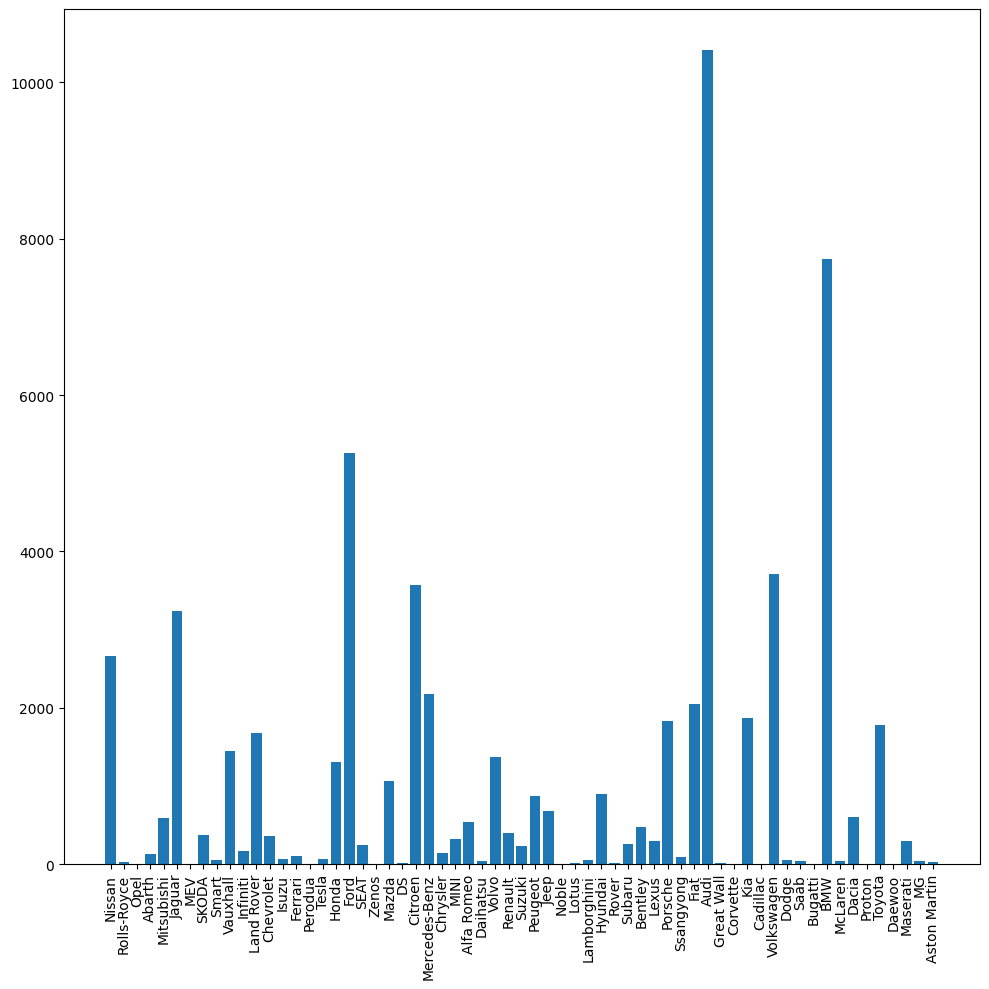

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.bar(image_counter.keys(), image_counter.values())
ax.tick_params(axis='x', rotation=90)

fig.tight_layout()

plt.show()

In [11]:
# https://github.com/ufoym/imbalanced-dataset-sampler/tree/master

class ImbalancedDatasetSampler(torch.utils.data.sampler.Sampler):
    """Samples elements randomly from a given list of indices for imbalanced dataset

    Arguments:
        indices: a list of indices
        num_samples: number of samples to draw
        callback_get_label: a callback-like function which takes two arguments - dataset and index
    """

    def __init__(
        self,
        dataset,
        labels: list = None,
        indices: list = None,
        num_samples: int = None,
        callback_get_label: Callable = None,
    ):
        # if indices is not provided, all elements in the dataset will be considered
        self.indices = list(range(len(dataset))) if indices is None else indices

        # define custom callback
        self.callback_get_label = callback_get_label

        # if num_samples is not provided, draw `len(indices)` samples in each iteration
        self.num_samples = len(self.indices) if num_samples is None else num_samples

        # distribution of classes in the dataset
        df = pd.DataFrame()
        df["label"] = self._get_labels(dataset) if labels is None else labels
        df.index = self.indices
        df = df.sort_index()

        label_to_count = df["label"].value_counts()

        weights = 1.0 / label_to_count[df["label"]]

        self.weights = torch.DoubleTensor(weights.to_list())

    def _get_labels(self, dataset):
        if self.callback_get_label:
            return self.callback_get_label(dataset)
        elif isinstance(dataset, torch.utils.data.TensorDataset):
            return dataset.tensors[1]
        elif isinstance(dataset, torchvision.datasets.MNIST):
            return dataset.train_labels.tolist()
        elif isinstance(dataset, torchvision.datasets.ImageFolder):
            return [x[1] for x in dataset.imgs]
        elif isinstance(dataset, torchvision.datasets.DatasetFolder):
            return dataset.samples[:][1]
        elif isinstance(dataset, torch.utils.data.Subset):
            return dataset.dataset.imgs[:][1]
        elif isinstance(dataset, torch.utils.data.Dataset):
            return dataset.get_labels()
        else:
            raise NotImplementedError

    def __iter__(self):
        return (self.indices[i] 
                for i in torch.multinomial(
                    self.weights, 
                    self.num_samples, 
                    replacement=True))

    def __len__(self):
        return self.num_samples

In [12]:
def show_pil_imgs(images):
    num_images = len(images)
    fig, axs = plt.subplots(1, num_images)
    if num_images == 1:
        axs = [axs]

    for i in range(num_images):
        axs[i].imshow(images[i])
        axs[i].axis('off')

    plt.show()

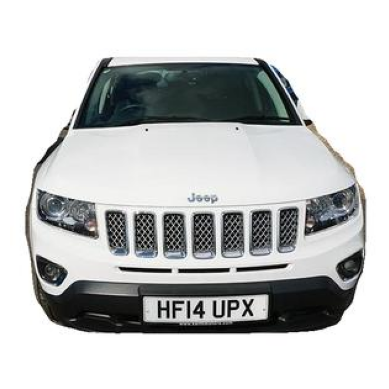

(300, 300)

In [13]:
img_path = './confirmed_fronts/Jeep/2014/Jeep$$Compass$$2014$$White$$40_3$$20$$image_0.jpg'
orig_pil_img = Image.open(img_path)
show_pil_imgs([orig_pil_img])
orig_pil_img.size

In [14]:
img_sz = 224

normalize = T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# Вопрос: что за нормализация такая? ^

train_data_transforms = T.Compose([
        T.Resize((img_sz, img_sz)),
        T.RandomHorizontalFlip(),
        T.RandomRotation(degrees=30),
        T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
        T.ToTensor(),
        # Важно про ToTensor (из документации):
        # Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255]
        # to a torch.FloatTensor of shape **(C x H x W) in the range [0.0, 1.0]**
        # if the PIL Image belongs to one of the modes (L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, 1)
        # or if the numpy.ndarray has dtype = np.uint8
        # Т.е. главное: на выходе имеем CxHxW fp32
        normalize
    ])

test_data_transforms = T.Compose([
    T.Resize((img_sz, img_sz)),
    T.ToTensor(),
    normalize
])

In [15]:
from torch.utils.data import Dataset
from PIL import Image
import pandas as pd

class ImageDataset(Dataset):
    def __init__(self, dataset_root, csv_filename, transform):
        print("Reading Image Dataset...")
        self.dataset_root = dataset_root
        self.classes = sorted([name for name in os.listdir(self.dataset_root)
                               if os.path.isdir(f'{self.dataset_root}/{name}')])
        self.label_to_idx = {val: idx for idx, val in enumerate(self.classes)}

        print("Reading dataset file paths...")
        self.img_labels = pd.read_csv(f'{dataset_root}/{csv_filename}', delimiter=',')
        self.transform = transform
        print("Image Dataset instance created!")

    def __len__(self):
        return len(self.img_labels)
    
    def get_labels(self):
        return list(map(self.label_to_idx.get, self.img_labels.iloc[:, 0]))

    def __getitem__(self, index):
        label = self.img_labels.iloc[index, 0]
        img_name = self.img_labels.iloc[index, 1]
        img_path = f'{self.dataset_root}/{img_name}'
        image = Image.open(img_path).convert('RGB')

        image_tensor = self.transform(image)
        image.close()
        return image_tensor, self.label_to_idx[label]

In [16]:
image_datasets = dict()
image_datasets['train'] = ImageDataset(dataset_root=dataset_root,
                                       csv_filename='train.csv',
                                       transform=train_data_transforms)
# image_datasets['train'] = torch.utils.data.Subset(image_datasets['train'], list(range(0, 200)))

image_datasets['test'] = ImageDataset(dataset_root=dataset_root,
                                      csv_filename='test.csv',
                                      transform=test_data_transforms)

Reading Image Dataset...
Reading dataset file paths...
Image Dataset instance created!
Reading Image Dataset...
Reading dataset file paths...
Image Dataset instance created!


In [17]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(seed)

batch_size = 32
num_workers = 2

dataloaders = dict()
dataloaders['train'] = DataLoader(image_datasets['train'],
                                  batch_size=batch_size,
                                  shuffle=True,
                                  num_workers=num_workers,
                                  pin_memory=True,
                                  drop_last=True,
                                  worker_init_fn=seed_worker,
                                  generator=g)
dataloaders['test'] = DataLoader(image_datasets['test'],
                                 batch_size=batch_size,
                                 shuffle=False,
                                 num_workers=num_workers,
                                 pin_memory=True,
                                 worker_init_fn=seed_worker,
                                 generator=g)

In [18]:
for X, y in dataloaders['test']:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([32, 3, 224, 224])
Shape of y: torch.Size([32]) torch.int64


# ResNet from scratch implementation

In [19]:
def get_out_size(input_size, kernel_size, stride_size=1, padding_size=0):
  return (input_size + 2 * padding_size - kernel_size) // stride_size + 1

In [20]:
get_out_size(224, kernel_size=7, stride_size=2, padding_size=3)

112

In [21]:
def conv3x3(
    in_planes: int,
    out_planes: int, 
    stride: int = 1, 
    dilation: int = 1
) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        bias=False,
        dilation=dilation,
    )

def conv1x1(
    in_planes: int, 
    out_planes: int, 
    stride: int = 1
) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=1,
        stride=stride,
        bias=False
    )

In [22]:
class Bottleneck(nn.Module):
    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        outplanes = planes * self.expansion
        
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        
        self.conv1 = conv1x1(inplanes, planes)
        self.bn1 = norm_layer(planes)
        
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn2 = norm_layer(planes)
        
        self.conv3 = conv1x1(planes, outplanes)
        self.bn3 = norm_layer(outplanes)
        
        self.relu = nn.ReLU(inplace=True)
        
        self.downsample = downsample

    def forward(self, x: Tensor) -> Tensor:
        # print(f"layer input shape {x.shape=}")
        
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)
        
        # out.shape=torch.Size([2, 256, 56, 56])
        # identity.shape=torch.Size([2, 64, 56, 56])
        # print(f"{out.shape=}")
        # print(f"{identity.shape=}")
        
        # print(f"identity {self.downsample=}")        
        if self.downsample is not None:
            identity = self.downsample(x)
        
        out += identity
        
        out = self.relu(out)

        # print()
        
        return out

In [23]:
class ResNet(nn.Module):
    def __init__(self, 
                 block,
                 layers: List[int],
                 num_classes: int, 
                 in_channels=3,
                 norm_layer: Optional[Callable[..., nn.Module]] = None,
    ):
        super(ResNet, self).__init__()
        self.inplanes = 64
        
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer
        
        self.conv1 = nn.Conv2d(in_channels, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        
        self.inplanes = planes * block.expansion
        
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        # print(f"initial {x.shape=}")
        x = self.conv1(x)
        # print(f"conv1 {x.shape=}")
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        # print(f"maxpool {x.shape=}")
        
        # print(f"{self.layer1=}")
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        # linear layers 
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x

# Training

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [25]:
model = ResNet(Bottleneck, [3, 4, 6, 3], num_classes).to(device)

In [26]:
!pip install torchsummary > /dev/null

In [27]:
from torchsummary import summary

summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [28]:
import torch.optim as optim

learning_rate = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [29]:
from sklearn import metrics

def run_epoch(phase, dataloader):
    if phase == 'train':
        model.train()
    else:
        model.eval()

    running_loss = 0.0
    running_corrects = 0
    y_test = []
    y_pred = []
    all_elems_count = 0
    cur_tqdm = tqdm(dataloader)
    for inputs, labels in cur_tqdm:
        bz = inputs.shape[0]
        all_elems_count += bz

        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        if phase == 'train':
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        _, preds = torch.max(outputs, 1)
        y_test.extend(labels.detach().cpu().numpy())
        y_pred.extend(preds.detach().cpu().numpy())
        running_loss += loss.item() * bz
        corrects_cnt = torch.sum(preds == labels.detach())
        running_corrects += corrects_cnt
        show_dict = {'Loss': f'{loss.item():.6f}',
                     'Corrects': f'{corrects_cnt.item()}/{bz}',
                     'Accuracy': f'{(corrects_cnt * 100 / bz).item():.3f}%'}
        cur_tqdm.set_postfix(show_dict)

    conf_matrix = metrics.confusion_matrix(y_test, y_pred, labels=range(num_classes))

    print("Calculating metrics...")
    f05_macro = metrics.fbeta_score(y_test, y_pred, average="macro", beta=0.5)
    f1_macro = metrics.f1_score(y_test, y_pred, average="macro")
    epoch_loss = running_loss / all_elems_count
    epoch_acc = running_corrects.float().item() / all_elems_count
    
    return epoch_loss, epoch_acc, f05_macro, f1_macro, conf_matrix

def test_epoch(dataloader):
    with torch.inference_mode(): # существенно ускоряет этап тестирования
        return run_epoch('test', dataloader)

def train_epoch(dataloader):
    return run_epoch('train', dataloader)

In [30]:
def vis(test_accs, confusion_mtxes, labels, figsize=(50, 80)):
    
    cm = confusion_mtxes[np.argmax(test_accs)]
    
    cm_sum = np.sum(cm, axis=0, keepdims=True)
    cm_perc = cm / cm_sum * 100
    
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%' % p
    
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    
    fig = plt.figure(figsize=figsize)
    
    plt.subplot(2, 1, 1)
    plt.plot(test_accs, 'g')
    plt.grid(True)
    
    plt.subplot(2, 1, 2)
    sns.heatmap(cm, annot=annot, fmt='', cmap="Blues", square=False)
    
    fig.tight_layout()
    
    plt.show()

In [31]:
import time
import math

log_folder = 'logs'
os.makedirs(log_folder, exist_ok=True)

def train_model(dataloaders, num_epochs=5):
    print(f"Training model with params:")
    print(f"Optim: {optimizer}")
    print(f"Criterion: {criterion}")
  
    phases = ['train', 'test']
    for phase in dataloaders:
        if phase not in phases:
            phases.append(phase)
  
    saved_epoch_losses = {phase: [] for phase in phases}
    saved_epoch_accuracies = {phase: [] for phase in phases}
    saved_epoch_f1_macros = {phase: [] for phase in phases}
    saved_epoch_conf_matrices = {phase: [] for phase in phases}
  
    for epoch in range(1, num_epochs + 1):
        start_time = time.time()
  
        print("=" * 100)
        print(f'Epoch {epoch}/{num_epochs}')
        print('-' * 10)
  
        for phase in phases:
            print("--- Cur phase:", phase)
            
            epoch_loss, epoch_acc, f05_macro, f1_macro, conf_matrix = \
                train_epoch(dataloaders[phase]) if phase == 'train' \
                    else test_epoch(dataloaders[phase])
            
            saved_epoch_losses[phase].append(epoch_loss)
            saved_epoch_accuracies[phase].append(epoch_acc)
            saved_epoch_f1_macros[phase].append(f1_macro)
            saved_epoch_conf_matrices[phase].append(conf_matrix)
            
            print(f'{phase} loss: {epoch_loss:.6f}, '
                  f'acc: {epoch_acc:.6f}, '
                  f'f05_macro: {f05_macro:.6f}, '
                  f'f1_macro: {f1_macro:.6f}')
            
            print("Confusion matrix:")
            print(conf_matrix)
  
        model.eval()
        if epoch > 1:
            plt.title(f'Losses during training. Epoch {epoch}/{num_epochs}.')
            plt.plot(range(1, epoch + 1), saved_epoch_losses['train'], label='Train Loss')
            plt.plot(range(1, epoch + 1), saved_epoch_losses['test'], label='Test Loss')
            plt.xlabel('Epochs')
            plt.ylabel(criterion.__class__.__name__)
            plt.legend(loc="upper left")
            plt.savefig(f'{log_folder}/loss_graph_epoch{epoch + 1}.png')
            plt.show()
            plt.close('all')
  
            plt.title(f'Accuracies during training. Epoch {epoch}/{num_epochs}.')
            plt.plot(range(1, epoch + 1), saved_epoch_accuracies['train'], label='Train Acc')
            plt.plot(range(1, epoch + 1), saved_epoch_accuracies['test'], label='Test Acc')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.legend(loc="upper left")
            plt.savefig(f'{log_folder}/acc_graph_epoch{epoch + 1}.png')
            plt.show()
            plt.close('all')
  
        end_time = time.time()
        epoch_time = end_time - start_time
        print("-" * 10)
        print(f"Epoch Time: {math.floor(epoch_time // 60)}:{math.floor(epoch_time % 60):02d}")
  
    print("*** Training Completed ***")
  
    return saved_epoch_losses, saved_epoch_accuracies, saved_epoch_f1_macros, saved_epoch_conf_matrices

Training model with params:
Optim: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
Criterion: CrossEntropyLoss()
Epoch 1/5
----------
--- Cur phase: train


100%|██████████| 1739/1739 [08:56<00:00,  3.24it/s, Loss=0.905374, Corrects=23/32, Accuracy=71.875%]


Calculating metrics...
train loss: 1.936675, acc: 0.479568, f05_macro: 0.173516, f1_macro: 0.150104
Confusion matrix:
[[   0    0    0 ...    2    0    0]
 [   0  124    0 ...   10    1    0]
 [   0    0    0 ...    2    5    0]
 ...
 [   0    0    0 ... 1573   20    0]
 [   0    0    0 ...   96  211    0]
 [   0    0    0 ...    0    0    0]]
--- Cur phase: test


100%|██████████| 193/193 [00:18<00:00, 10.62it/s, Loss=5.168851, Corrects=0/13, Accuracy=0.000%]   


Calculating metrics...
test loss: 1.204674, acc: 0.660062, f05_macro: 0.311637, f1_macro: 0.275900
Confusion matrix:
[[  0   0   0 ...   1   0   0]
 [  0  44   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ... 208   7   0]
 [  0   0   0 ...   1  55   0]
 [  0   0   0 ...   0   0   0]]
----------
Epoch Time: 9:14
Epoch 2/5
----------
--- Cur phase: train


100%|██████████| 1739/1739 [09:01<00:00,  3.21it/s, Loss=0.206536, Corrects=30/32, Accuracy=93.750%] 


Calculating metrics...
train loss: 0.666769, acc: 0.821683, f05_macro: 0.414738, f1_macro: 0.390711
Confusion matrix:
[[  12    0    0 ...    2    0    0]
 [   0  423    0 ...    1    1    0]
 [   0    1    2 ...    0    3    0]
 ...
 [   0    0    0 ... 2893   30    0]
 [   0    0    0 ...   36  844    0]
 [   0    0    0 ...    0    0    0]]
--- Cur phase: test


100%|██████████| 193/193 [00:18<00:00, 10.60it/s, Loss=2.470484, Corrects=6/13, Accuracy=46.154%]  


Calculating metrics...
test loss: 0.385169, acc: 0.895728, f05_macro: 0.598700, f1_macro: 0.565818
Confusion matrix:
[[  3   0   0 ...   0   0   0]
 [  0  50   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ... 357   0   0]
 [  0   0   0 ...   1 114   0]
 [  0   0   0 ...   0   0   0]]


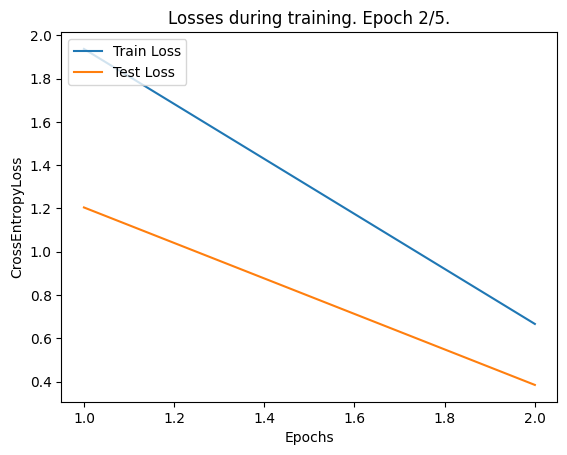

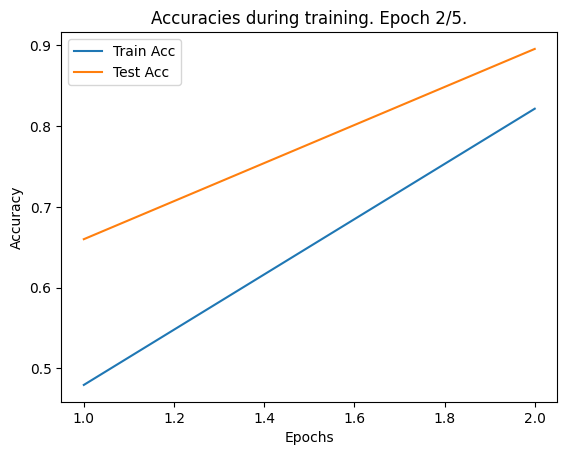

----------
Epoch Time: 9:20
Epoch 3/5
----------
--- Cur phase: train


100%|██████████| 1739/1739 [09:01<00:00,  3.21it/s, Loss=0.430042, Corrects=30/32, Accuracy=93.750%] 


Calculating metrics...
train loss: 0.360947, acc: 0.901686, f05_macro: 0.535663, f1_macro: 0.515415
Confusion matrix:
[[  45    0    0 ...    1    0    0]
 [   0  463    0 ...    1    0    0]
 [   0    0    5 ...    0    1    0]
 ...
 [   0    0    1 ... 3123   10    0]
 [   0    0    0 ...    5 1083    0]
 [   0    0    0 ...    0    0    0]]
--- Cur phase: test


100%|██████████| 193/193 [00:18<00:00, 10.60it/s, Loss=1.577175, Corrects=7/13, Accuracy=53.846%]  


Calculating metrics...
test loss: 0.276532, acc: 0.925288, f05_macro: 0.694663, f1_macro: 0.662973
Confusion matrix:
[[  5   0   0 ...   0   0   0]
 [  0  51   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ... 352   0   0]
 [  0   0   0 ...   0 128   0]
 [  0   0   0 ...   0   0   0]]


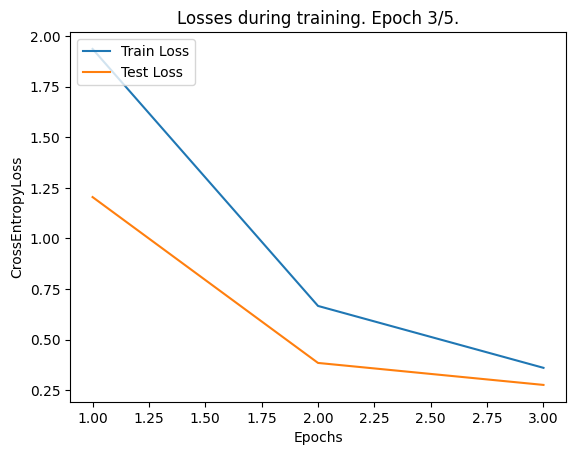

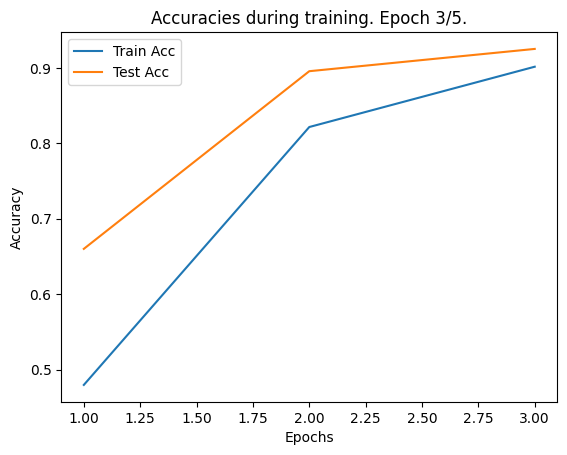

----------
Epoch Time: 9:20
Epoch 4/5
----------
--- Cur phase: train


100%|██████████| 1739/1739 [09:01<00:00,  3.21it/s, Loss=0.278965, Corrects=29/32, Accuracy=90.625%] 


Calculating metrics...
train loss: 0.254252, acc: 0.931049, f05_macro: 0.613406, f1_macro: 0.594735
Confusion matrix:
[[  68    0    0 ...    1    0    0]
 [   0  471    0 ...    0    0    0]
 [   0    0   18 ...    0    0    0]
 ...
 [   2    0    0 ... 3196    1    0]
 [   0    0    0 ...    4 1122    0]
 [   0    0    0 ...    0    0    0]]
--- Cur phase: test


100%|██████████| 193/193 [00:18<00:00, 10.31it/s, Loss=1.577477, Corrects=8/13, Accuracy=61.538%]  


Calculating metrics...
test loss: 0.271654, acc: 0.928699, f05_macro: 0.709606, f1_macro: 0.681457
Confusion matrix:
[[  7   0   0 ...   0   0   0]
 [  0  52   0 ...   0   0   0]
 [  0   0   0 ...   0   1   0]
 ...
 [  0   0   0 ... 369   0   0]
 [  0   0   0 ...   8 119   0]
 [  0   0   0 ...   0   0   0]]


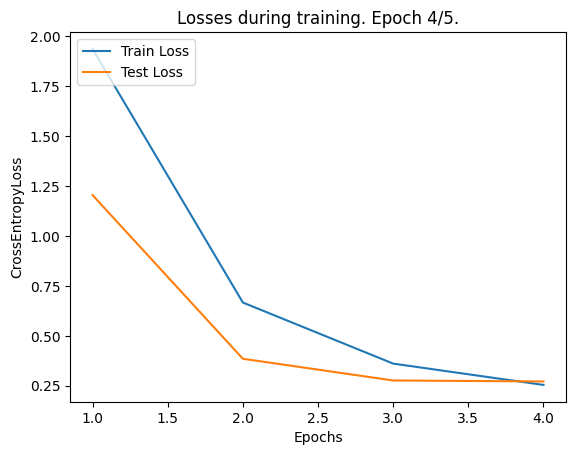

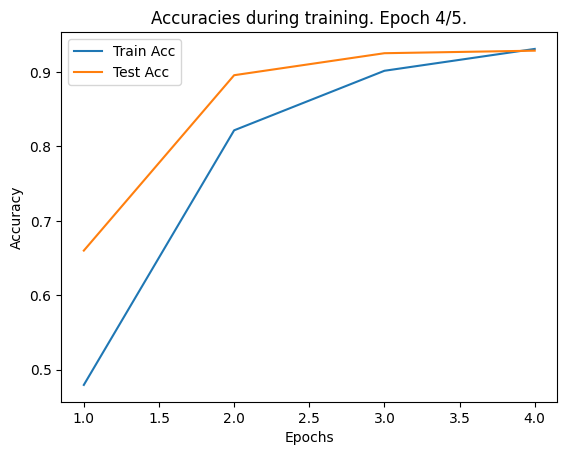

----------
Epoch Time: 9:21
Epoch 5/5
----------
--- Cur phase: train


100%|██████████| 1739/1739 [09:01<00:00,  3.21it/s, Loss=0.115761, Corrects=31/32, Accuracy=96.875%] 


Calculating metrics...
train loss: 0.192044, acc: 0.948120, f05_macro: 0.663785, f1_macro: 0.644311
Confusion matrix:
[[  77    0    0 ...    0    0    0]
 [   0  471    0 ...    1    0    0]
 [   0    0   19 ...    0    0    0]
 ...
 [   1    0    0 ... 3245    2    0]
 [   0    0    0 ...    2 1172    0]
 [   0    0    0 ...    0    0    0]]
--- Cur phase: test


100%|██████████| 193/193 [00:18<00:00, 10.19it/s, Loss=0.667197, Corrects=12/13, Accuracy=92.308%] 


Calculating metrics...
test loss: 0.228885, acc: 0.936982, f05_macro: 0.723427, f1_macro: 0.707578
Confusion matrix:
[[  8   1   0 ...   0   0   0]
 [  0  53   0 ...   0   0   0]
 [  0   0   2 ...   0   0   0]
 ...
 [  0   0   0 ... 362   0   0]
 [  0   0   0 ...   0 126   0]
 [  0   0   0 ...   0   0   0]]


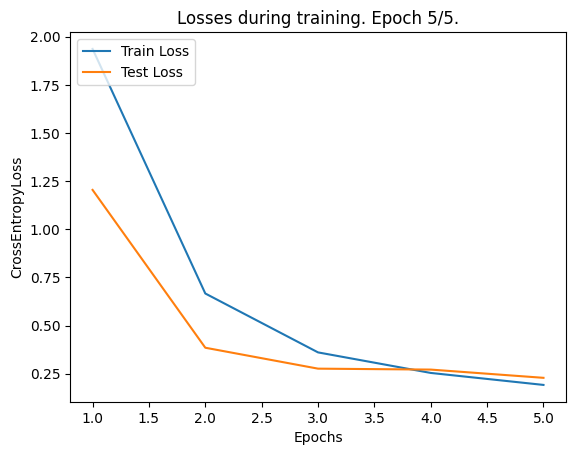

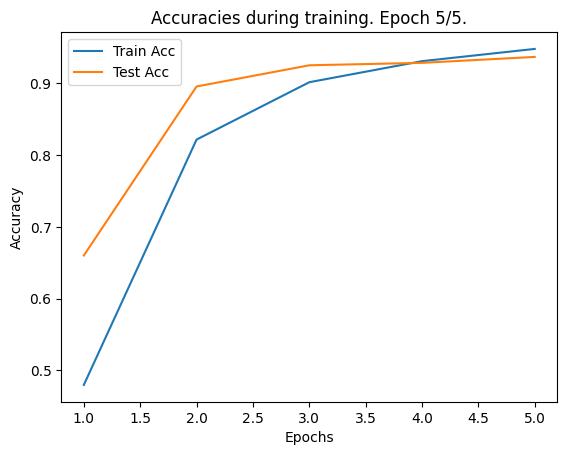

----------
Epoch Time: 9:21
*** Training Completed ***


/tmp/ipykernel_30/3778819328.py:6: RuntimeWarning: invalid value encountered in divide
  cm_perc = cm / cm_sum * 100


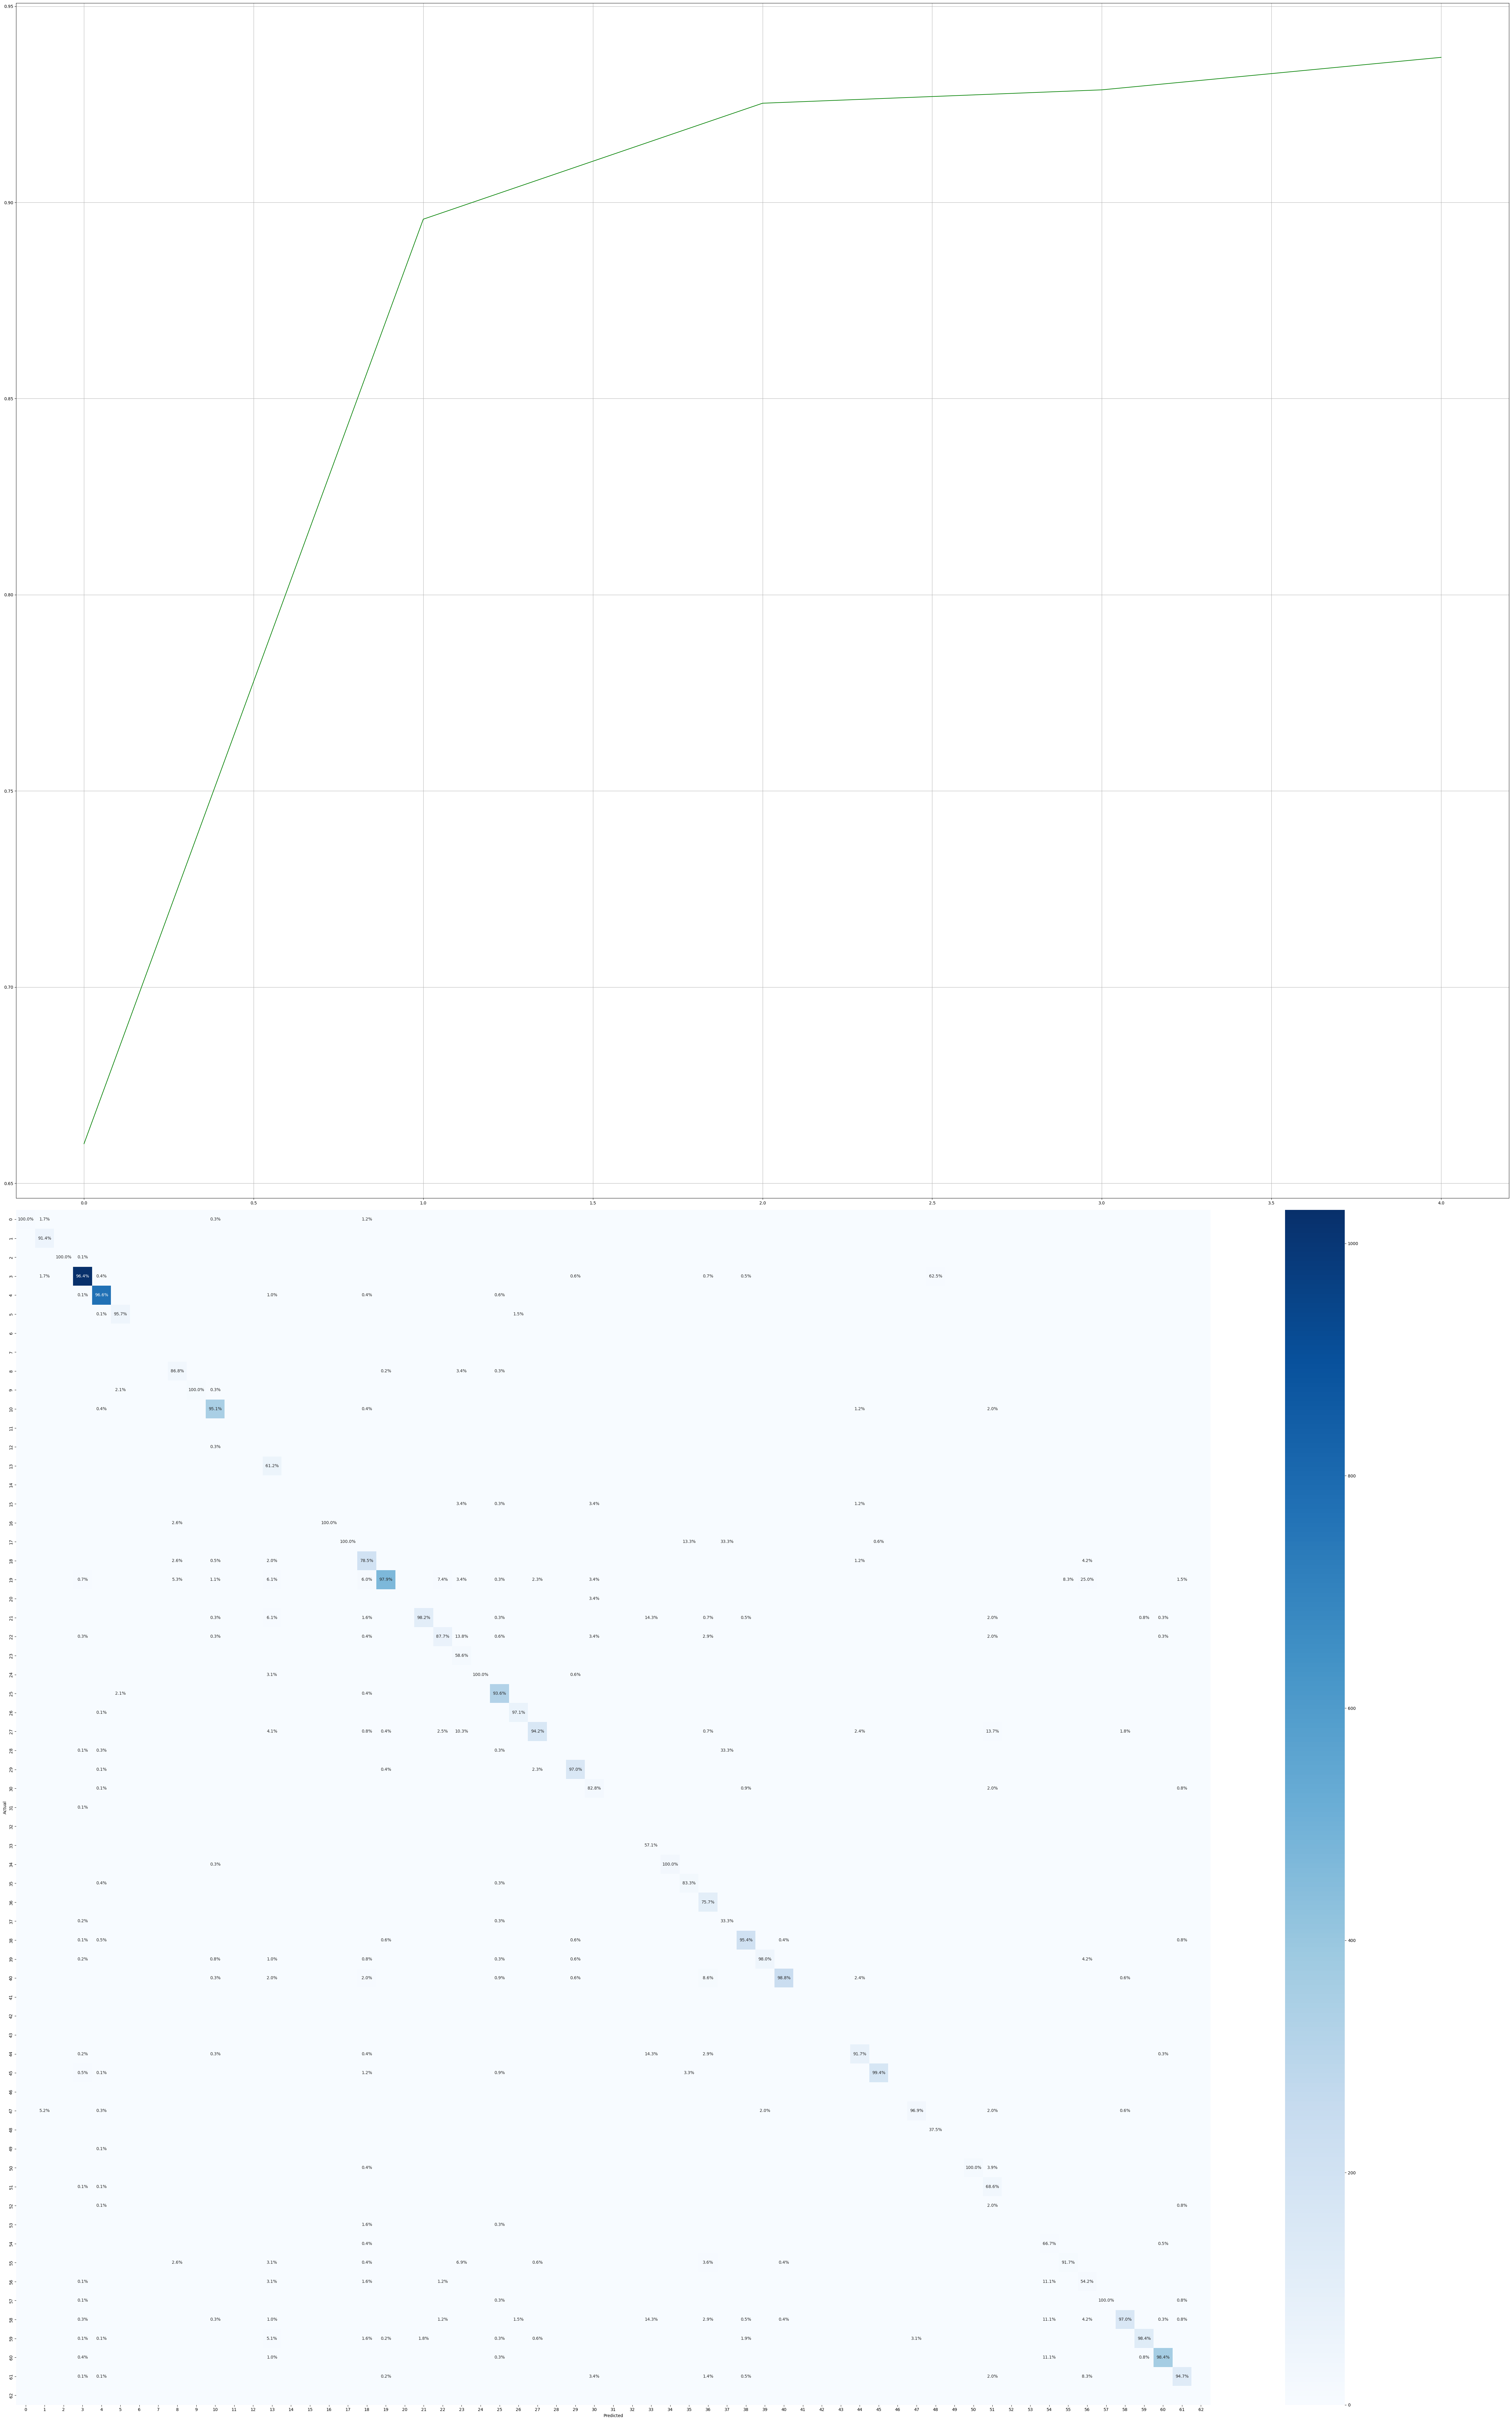

In [32]:
num_epochs = 5
classe_labels = range(num_classes)

losses, accuracies, f1_macros, conf_matrices = train_model(dataloaders, num_epochs)
vis(accuracies['test'], conf_matrices['test'], classe_labels)

In [49]:
model = ResNet(Bottleneck, [3, 4, 6, 3], num_classes).to(device)

learning_rate = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Training model with params:
Optim: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
Criterion: CrossEntropyLoss()
Epoch 1/5
----------
--- Cur phase: train


100%|██████████| 1739/1739 [09:00<00:00,  3.22it/s, Loss=0.071800, Corrects=31/32, Accuracy=96.875%] 


Calculating metrics...
train loss: 0.144390, acc: 0.957986, f05_macro: 0.957593, f1_macro: 0.957613
Confusion matrix:
[[878   0   0 ...   0   0   0]
 [  0 929   0 ...   1   0   0]
 [  0   0 853 ...   0   0   0]
 ...
 [  1   0   0 ... 778   2   0]
 [  0   0   0 ...   4 781   0]
 [  0   0   0 ...   0   0 919]]
--- Cur phase: test


100%|██████████| 193/193 [00:18<00:00, 10.65it/s, Loss=0.472316, Corrects=12/13, Accuracy=92.308%] 


Calculating metrics...
test loss: 0.312425, acc: 0.916518, f05_macro: 0.748117, f1_macro: 0.758041
Confusion matrix:
[[ 13   0   0 ...   0   0   0]
 [  0  53   0 ...   0   0   0]
 [  0   0   3 ...   0   0   0]
 ...
 [  0   1   0 ... 365   0   0]
 [  0   0   0 ...   2 125   0]
 [  0   0   0 ...   0   0   0]]
----------
Epoch Time: 9:18
Epoch 2/5
----------
--- Cur phase: train


100%|██████████| 1739/1739 [08:59<00:00,  3.22it/s, Loss=0.053553, Corrects=32/32, Accuracy=100.000%]


Calculating metrics...
train loss: 0.118003, acc: 0.967133, f05_macro: 0.967049, f1_macro: 0.967059
Confusion matrix:
[[880   0   0 ...   0   0   0]
 [  0 861   0 ...   0   0   0]
 [  0   0 904 ...   0   0   0]
 ...
 [  0   0   0 ... 801   2   0]
 [  0   0   0 ...   0 810   0]
 [  0   0   0 ...   0   0 904]]
--- Cur phase: test


100%|██████████| 193/193 [00:18<00:00, 10.64it/s, Loss=0.193497, Corrects=12/13, Accuracy=92.308%] 


Calculating metrics...
test loss: 0.271680, acc: 0.920741, f05_macro: 0.769632, f1_macro: 0.784848
Confusion matrix:
[[ 11   0   1 ...   0   0   0]
 [  0  53   0 ...   0   0   0]
 [  0   0   3 ...   0   0   0]
 ...
 [  0   0   0 ... 368   0   0]
 [  0   0   0 ...   0 131   0]
 [  0   0   0 ...   0   0   0]]


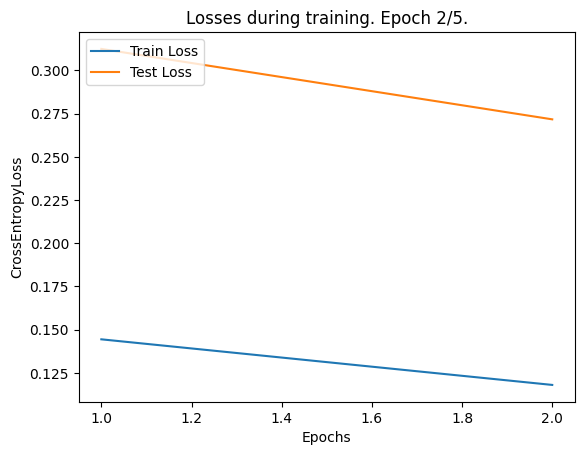

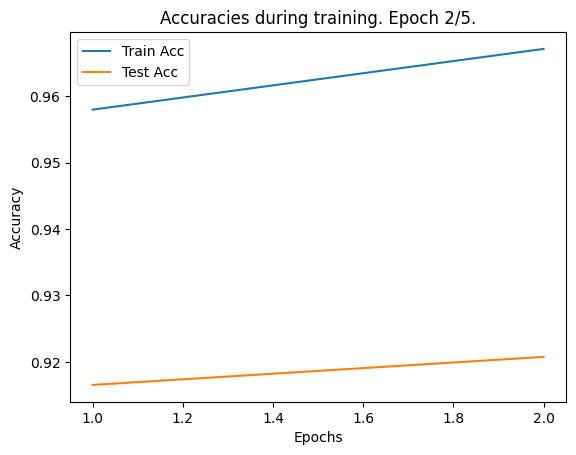

----------
Epoch Time: 9:18
Epoch 3/5
----------
--- Cur phase: train


100%|██████████| 1739/1739 [09:00<00:00,  3.22it/s, Loss=0.011013, Corrects=32/32, Accuracy=100.000%]


Calculating metrics...
train loss: 0.102664, acc: 0.970673, f05_macro: 0.970503, f1_macro: 0.970511
Confusion matrix:
[[854   0   0 ...   0   0   0]
 [  0 836   0 ...   0   0   0]
 [  0   0 877 ...   0   0   0]
 ...
 [  1   0   0 ... 878   0   0]
 [  0   0   0 ...   1 826   0]
 [  0   0   0 ...   0   0 883]]
--- Cur phase: test


100%|██████████| 193/193 [00:18<00:00, 10.62it/s, Loss=0.142224, Corrects=13/13, Accuracy=100.000%]


Calculating metrics...
test loss: 0.152759, acc: 0.958096, f05_macro: 0.822223, f1_macro: 0.842236
Confusion matrix:
[[ 13   0   0 ...   0   0   0]
 [  0  53   0 ...   0   0   0]
 [  0   0   3 ...   0   0   0]
 ...
 [  0   0   0 ... 355   0   0]
 [  0   0   0 ...   0 123   0]
 [  0   0   0 ...   0   0   0]]


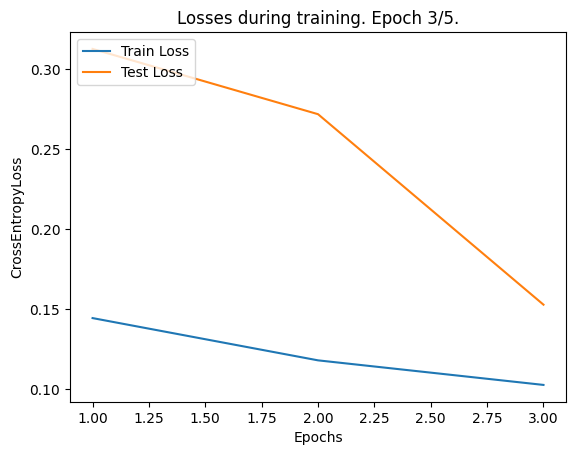

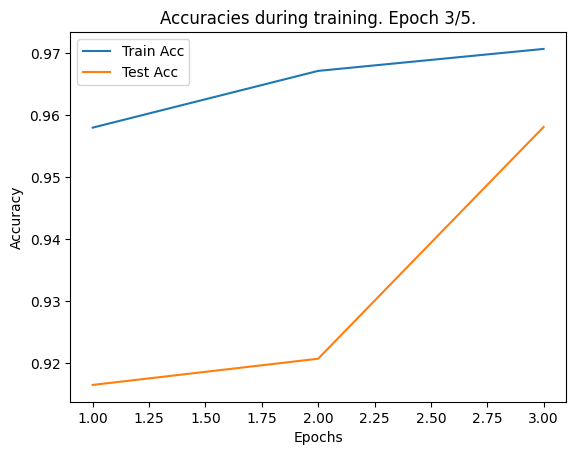

----------
Epoch Time: 9:19
Epoch 4/5
----------
--- Cur phase: train


100%|██████████| 1739/1739 [09:01<00:00,  3.21it/s, Loss=0.124539, Corrects=31/32, Accuracy=96.875%] 


Calculating metrics...
train loss: 0.087049, acc: 0.975417, f05_macro: 0.975332, f1_macro: 0.975333
Confusion matrix:
[[875   0   0 ...   0   0   0]
 [  0 876   0 ...   0   0   0]
 [  0   0 899 ...   0   0   0]
 ...
 [  0   0   0 ... 781   2   0]
 [  0   0   0 ...   0 820   0]
 [  0   0   0 ...   0   0 927]]
--- Cur phase: test


100%|██████████| 193/193 [00:18<00:00, 10.60it/s, Loss=0.949693, Corrects=10/13, Accuracy=76.923%] 


Calculating metrics...
test loss: 0.179548, acc: 0.954361, f05_macro: 0.788753, f1_macro: 0.800539
Confusion matrix:
[[ 12   0   0 ...   0   0   0]
 [  0  53   0 ...   0   0   0]
 [  0   0   2 ...   0   0   0]
 ...
 [  0   0   0 ... 361   0   0]
 [  0   0   0 ...   1 131   0]
 [  0   0   0 ...   0   0   0]]


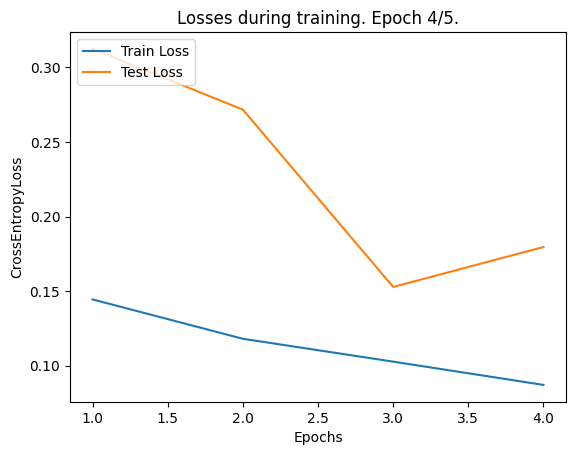

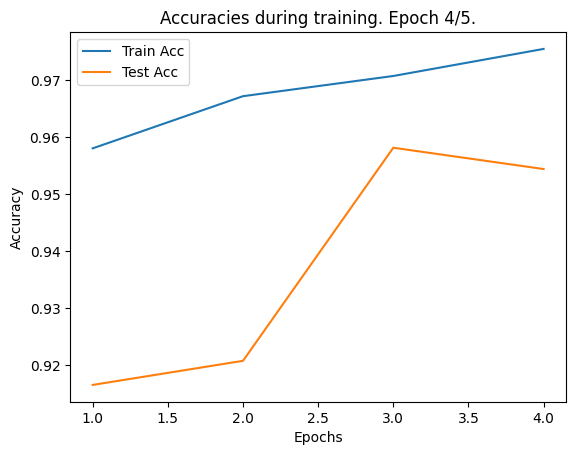

----------
Epoch Time: 9:20
Epoch 5/5
----------
--- Cur phase: train


100%|██████████| 1739/1739 [09:00<00:00,  3.22it/s, Loss=0.011969, Corrects=32/32, Accuracy=100.000%]


Calculating metrics...
train loss: 0.080585, acc: 0.976136, f05_macro: 0.976234, f1_macro: 0.976255
Confusion matrix:
[[849   0   0 ...   0   0   0]
 [  0 885   0 ...   1   0   0]
 [  0   0 885 ...   0   0   0]
 ...
 [  0   0   0 ... 825   3   0]
 [  0   0   0 ...   0 859   0]
 [  0   0   0 ...   0   0 884]]
--- Cur phase: test


100%|██████████| 193/193 [00:18<00:00, 10.62it/s, Loss=0.538250, Corrects=12/13, Accuracy=92.308%] 


Calculating metrics...
test loss: 0.143323, acc: 0.962482, f05_macro: 0.837610, f1_macro: 0.850278
Confusion matrix:
[[ 11   0   0 ...   0   1   0]
 [  0  53   0 ...   0   0   0]
 [  0   0   3 ...   0   0   0]
 ...
 [  0   0   0 ... 366   0   0]
 [  0   0   0 ...   0 135   0]
 [  0   0   0 ...   0   0   0]]


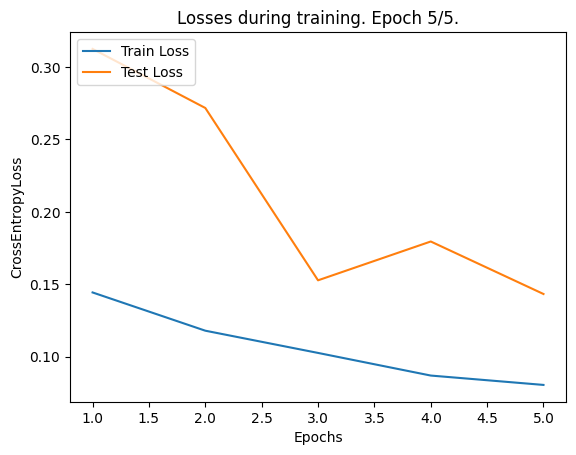

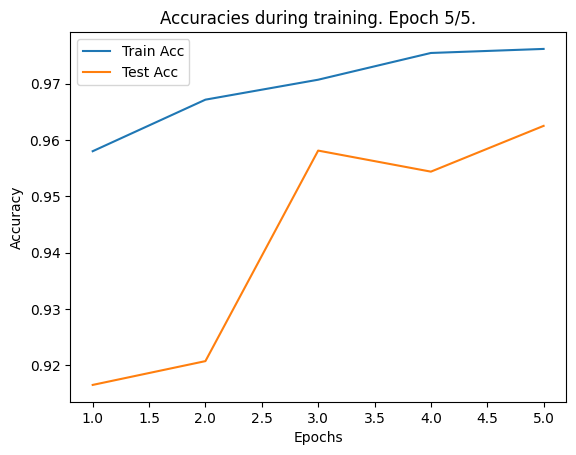

----------
Epoch Time: 9:19
*** Training Completed ***


/tmp/ipykernel_30/3778819328.py:6: RuntimeWarning: invalid value encountered in divide
  cm_perc = cm / cm_sum * 100


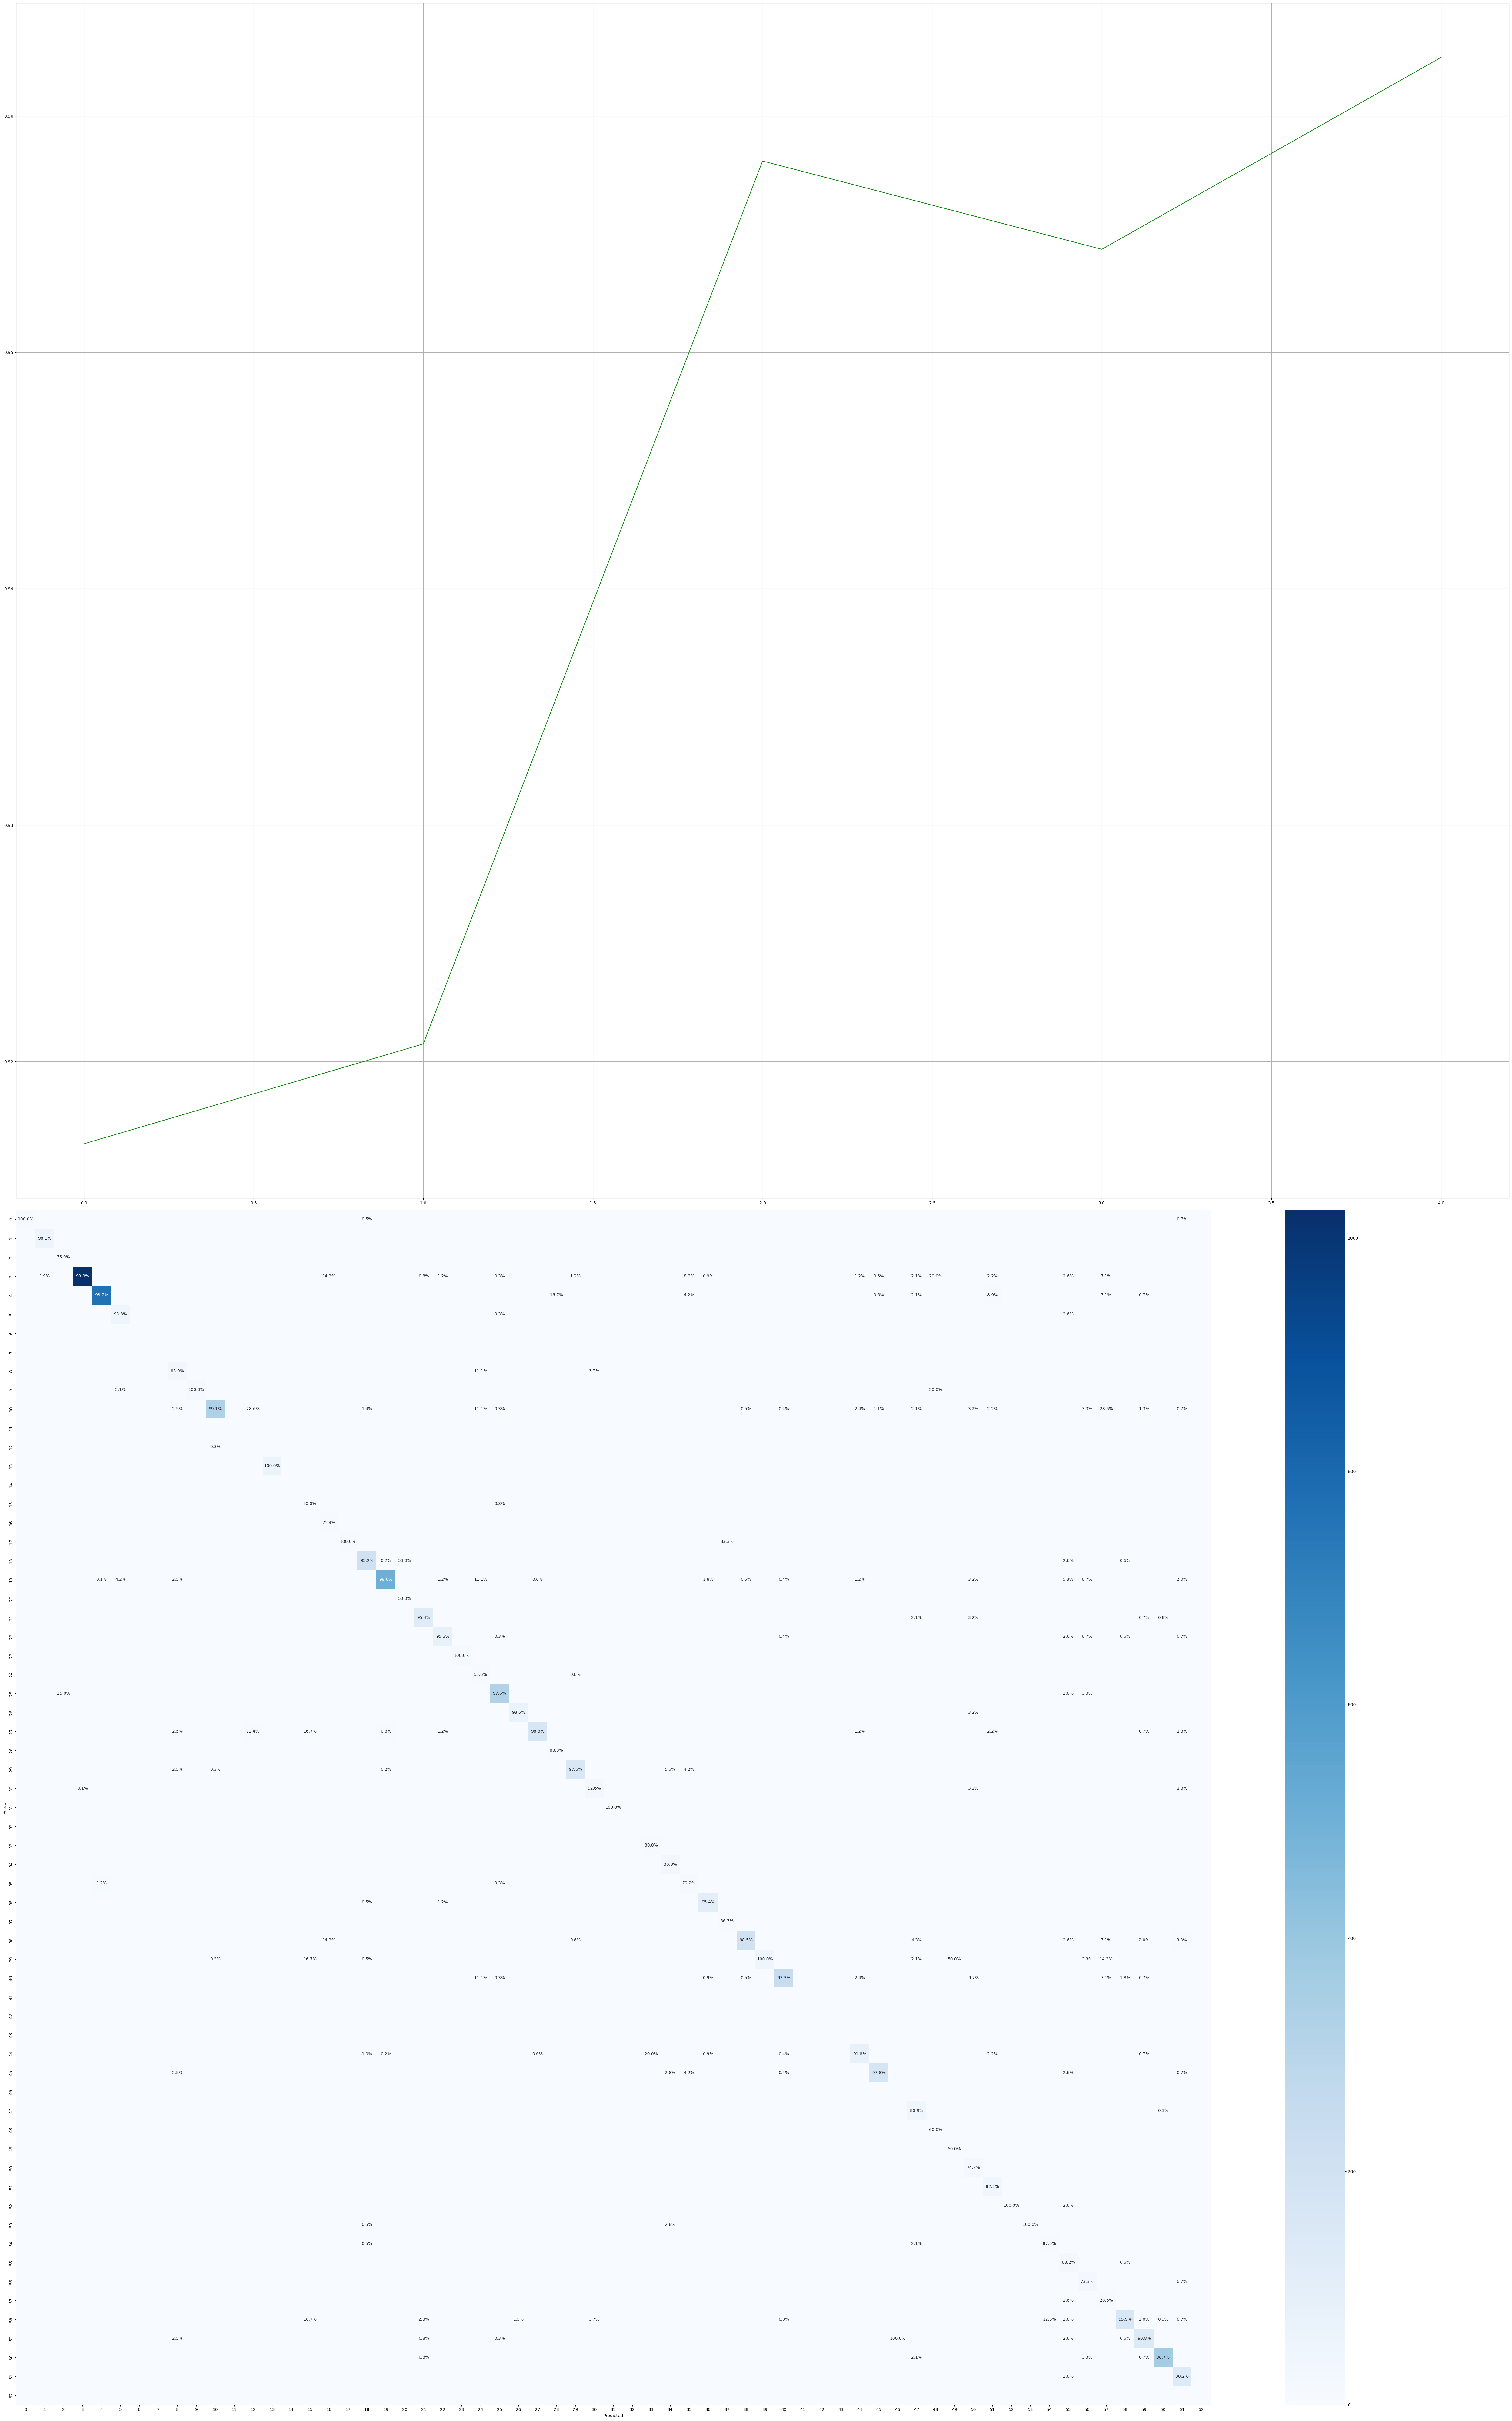

In [50]:
dataloaders = dict()
dataloaders['train'] = DataLoader(image_datasets['train'],
                                  sampler=ImbalancedDatasetSampler(image_datasets['train']),
                                  batch_size=batch_size,
                                  num_workers=num_workers,
                                  pin_memory=True,
                                  drop_last=True,
                                  worker_init_fn=seed_worker,
                                  generator=g)
dataloaders['test'] = DataLoader(image_datasets['test'],
                                 batch_size=batch_size,
                                 shuffle=False,
                                 num_workers=num_workers,
                                 pin_memory=True,
                                 worker_init_fn=seed_worker,
                                 generator=g)

losses, accuracies, f1_macros, conf_matrices = train_model(dataloaders, num_epochs)
vis(accuracies['test'], conf_matrices['test'], classe_labels)

# Saving and loading trained weights

In [37]:
resnet50_ckpt_path = f'my_trained_resnet50_with_sampler_{num_epochs}.pth'
torch.save(model.state_dict(), resnet50_ckpt_path)

In [48]:
model = ResNet(Bottleneck, [3, 4, 6, 3], num_classes).to(device)
model.load_state_dict(torch.load(resnet50_ckpt_path, map_location=torch.device('cuda')))

/tmp/ipykernel_30/3728617205.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(resnet50_ckpt_path, map_location=torch.device('cuda')))


<All keys matched successfully>

# ResNet with pretrained on ImageNet

In [38]:
import torch
import torchvision
from torchvision import models
from torch import nn
import torchvision.transforms as T

In [39]:
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
model

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 160MB/s] 


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [40]:
for name, p in model.named_parameters():
  print(name, p.shape)

conv1.weight torch.Size([64, 3, 7, 7])
bn1.weight torch.Size([64])
bn1.bias torch.Size([64])
layer1.0.conv1.weight torch.Size([64, 64, 1, 1])
layer1.0.bn1.weight torch.Size([64])
layer1.0.bn1.bias torch.Size([64])
layer1.0.conv2.weight torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight torch.Size([64])
layer1.0.bn2.bias torch.Size([64])
layer1.0.conv3.weight torch.Size([256, 64, 1, 1])
layer1.0.bn3.weight torch.Size([256])
layer1.0.bn3.bias torch.Size([256])
layer1.0.downsample.0.weight torch.Size([256, 64, 1, 1])
layer1.0.downsample.1.weight torch.Size([256])
layer1.0.downsample.1.bias torch.Size([256])
layer1.1.conv1.weight torch.Size([64, 256, 1, 1])
layer1.1.bn1.weight torch.Size([64])
layer1.1.bn1.bias torch.Size([64])
layer1.1.conv2.weight torch.Size([64, 64, 3, 3])
layer1.1.bn2.weight torch.Size([64])
layer1.1.bn2.bias torch.Size([64])
layer1.1.conv3.weight torch.Size([256, 64, 1, 1])
layer1.1.bn3.weight torch.Size([256])
layer1.1.bn3.bias torch.Size([256])
layer1.2.conv1.weight tor

In [41]:
def get_my_resnet_50(num_classes):
    resnet_features = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    resnet_features.requires_grad_(False)
    resnet_features.fc = nn.Sequential(
        nn.Linear(2048, 1024),
        nn.Dropout(0.1),
        nn.ReLU(),
        nn.Linear(1024, 256),
        nn.Dropout(0.1),
        nn.ReLU(),
        nn.Linear(256, num_classes)
    )
    return resnet_features

In [42]:
model = get_my_resnet_50(num_classes=num_classes).to(device)

In [43]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Training model with params:
Optim: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Criterion: CrossEntropyLoss()
Epoch 1/10
----------
--- Cur phase: train


100%|██████████| 1739/1739 [04:49<00:00,  6.01it/s, Loss=0.594582, Corrects=26/32, Accuracy=81.250%]


Calculating metrics...
train loss: 1.592213, acc: 0.584963, f05_macro: 0.563907, f1_macro: 0.568767
Confusion matrix:
[[578   0   0 ...   1   2   0]
 [ 11 479   9 ...   4   7   3]
 [  0   2 768 ...   2   3   1]
 ...
 [ 10   3  11 ... 400  19   0]
 [  0  18  25 ...  31 189   1]
 [  0   0   1 ...   0   0 830]]
--- Cur phase: test


100%|██████████| 193/193 [00:18<00:00, 10.69it/s, Loss=2.174117, Corrects=6/13, Accuracy=46.154%] 


Calculating metrics...
test loss: 1.391457, acc: 0.610687, f05_macro: 0.366168, f1_macro: 0.371441
Confusion matrix:
[[  5   0   0 ...   0   0   0]
 [  0  42   0 ...   0   0   0]
 [  0   1   1 ...   0   0   0]
 ...
 [  0   0   2 ... 255   2   0]
 [  0   1   0 ...   3  52   0]
 [  0   0   0 ...   0   0   0]]
----------
Epoch Time: 5:07
Epoch 2/10
----------
--- Cur phase: train


100%|██████████| 1739/1739 [04:51<00:00,  5.97it/s, Loss=0.329943, Corrects=27/32, Accuracy=84.375%]


Calculating metrics...
train loss: 0.854311, acc: 0.764592, f05_macro: 0.756938, f1_macro: 0.758843
Confusion matrix:
[[722   3   0 ...   0   0   0]
 [  4 686   2 ...   0   3   0]
 [  0   2 866 ...   1   1   0]
 ...
 [  2   2   1 ... 596  10   0]
 [  0   6   3 ...  20 401   0]
 [  0   0   0 ...   0   0 928]]
--- Cur phase: test


100%|██████████| 193/193 [00:18<00:00, 10.64it/s, Loss=2.951756, Corrects=4/13, Accuracy=30.769%] 


Calculating metrics...
test loss: 1.365324, acc: 0.624817, f05_macro: 0.428877, f1_macro: 0.429042
Confusion matrix:
[[ 10   0   0 ...   0   0   0]
 [  0  45   0 ...   0   0   0]
 [  0   0   1 ...   0   0   0]
 ...
 [  0   0   0 ... 246   3   0]
 [  0   0   0 ...   1  61   0]
 [  0   0   0 ...   0   0   0]]


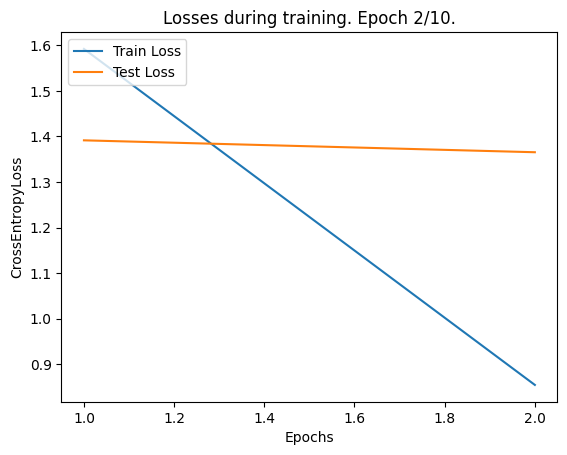

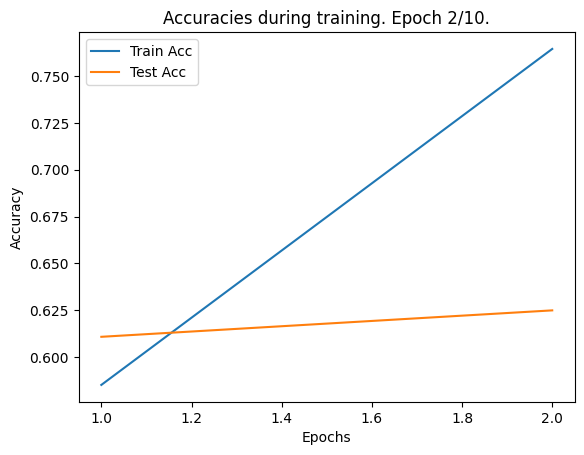

----------
Epoch Time: 5:10
Epoch 3/10
----------
--- Cur phase: train


100%|██████████| 1739/1739 [04:59<00:00,  5.80it/s, Loss=0.380355, Corrects=29/32, Accuracy=90.625%] 


Calculating metrics...
train loss: 0.704523, acc: 0.805492, f05_macro: 0.800239, f1_macro: 0.801433
Confusion matrix:
[[786   0   0 ...   2   0   0]
 [  4 738   0 ...   0   4   0]
 [  0   0 814 ...   1   2   0]
 ...
 [  6   1   1 ... 647  10   0]
 [  0   4   2 ...  17 514   0]
 [  0   0   0 ...   0   0 928]]
--- Cur phase: test


100%|██████████| 193/193 [00:18<00:00, 10.61it/s, Loss=1.729992, Corrects=8/13, Accuracy=61.538%] 


Calculating metrics...
test loss: 1.045074, acc: 0.705863, f05_macro: 0.462424, f1_macro: 0.487955
Confusion matrix:
[[ 10   0   0 ...   0   1   0]
 [  0  49   0 ...   0   0   0]
 [  0   0   2 ...   0   0   0]
 ...
 [  0   0   1 ... 274   6   0]
 [  0   2   0 ...   1  87   0]
 [  0   0   0 ...   0   0   0]]


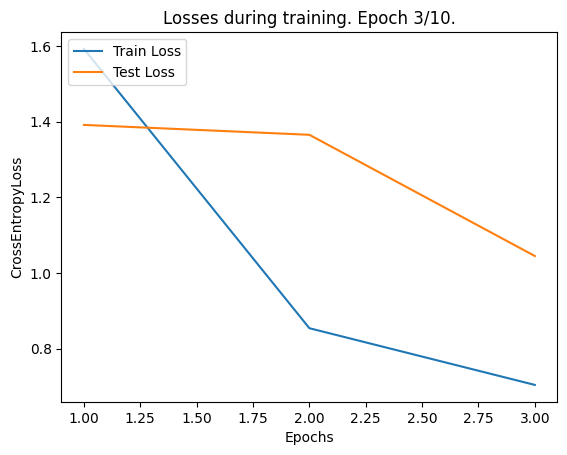

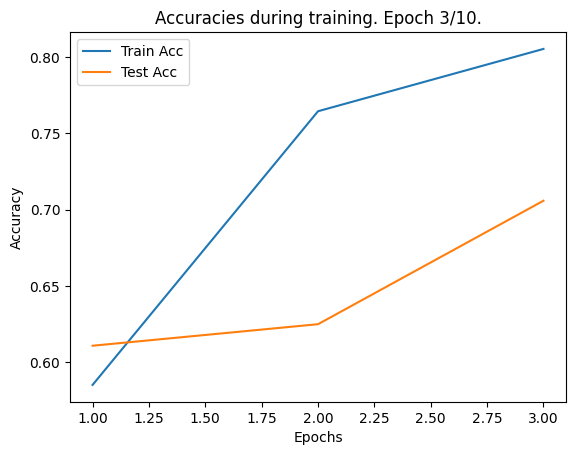

----------
Epoch Time: 5:19
Epoch 4/10
----------
--- Cur phase: train


100%|██████████| 1739/1739 [04:53<00:00,  5.93it/s, Loss=0.387006, Corrects=29/32, Accuracy=90.625%] 


Calculating metrics...
train loss: 0.625171, acc: 0.826121, f05_macro: 0.823180, f1_macro: 0.824174
Confusion matrix:
[[764   2   0 ...   2   1   0]
 [  3 713   0 ...   1   5   0]
 [  0   0 839 ...   0   0   0]
 ...
 [  1   0   2 ... 642   9   0]
 [  0   3   1 ...  19 513   0]
 [  0   0   0 ...   0   0 878]]
--- Cur phase: test


100%|██████████| 193/193 [00:17<00:00, 10.73it/s, Loss=1.159567, Corrects=11/13, Accuracy=84.615%] 


Calculating metrics...
test loss: 1.193669, acc: 0.670944, f05_macro: 0.462313, f1_macro: 0.465495
Confusion matrix:
[[  6   0   0 ...   0   1   0]
 [  0  45   0 ...   0   0   0]
 [  0   0   1 ...   1   0   0]
 ...
 [  0   0   0 ... 332   0   0]
 [  0   0   0 ...  14  66   0]
 [  0   0   0 ...   0   0   0]]


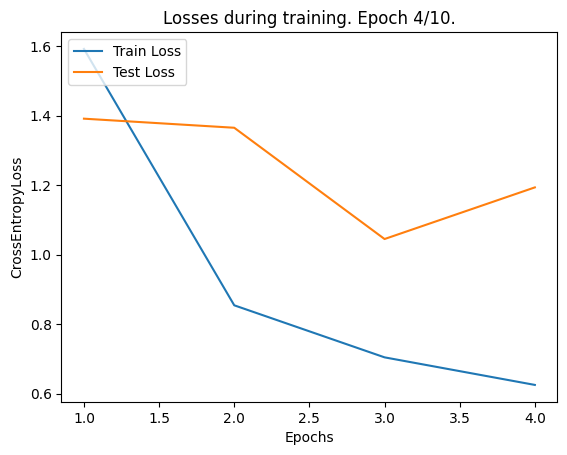

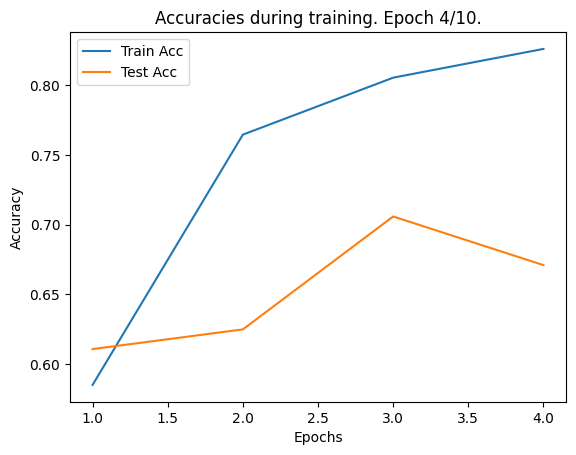

----------
Epoch Time: 5:12
Epoch 5/10
----------
--- Cur phase: train


100%|██████████| 1739/1739 [04:59<00:00,  5.81it/s, Loss=1.007408, Corrects=24/32, Accuracy=75.000%] 


Calculating metrics...
train loss: 0.573228, acc: 0.839545, f05_macro: 0.836898, f1_macro: 0.837720
Confusion matrix:
[[780   0   0 ...   0   0   0]
 [  2 792   0 ...   2   3   0]
 [  0   0 852 ...   1   0   0]
 ...
 [  1   1   1 ... 656  13   0]
 [  1   3   1 ...  14 563   0]
 [  0   0   0 ...   0   0 891]]
--- Cur phase: test


100%|██████████| 193/193 [00:18<00:00, 10.56it/s, Loss=2.339880, Corrects=6/13, Accuracy=46.154%]  


Calculating metrics...
test loss: 1.082033, acc: 0.693844, f05_macro: 0.516250, f1_macro: 0.514241
Confusion matrix:
[[  5   0   0 ...   0   1   0]
 [  0  37   0 ...   0   0   0]
 [  0   0   1 ...   0   0   0]
 ...
 [  0   0   0 ... 246   2   0]
 [  0   0   0 ...   0  67   0]
 [  0   0   0 ...   0   0   0]]


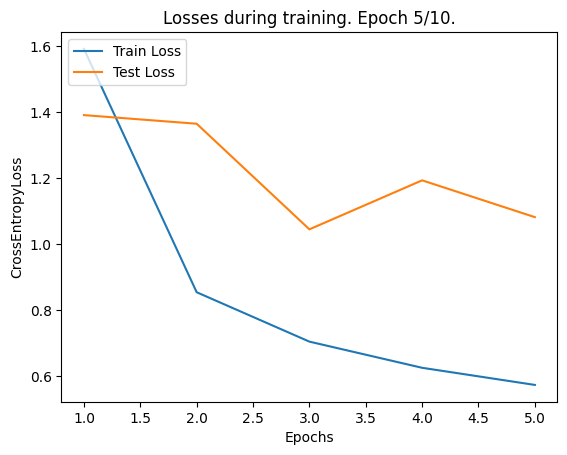

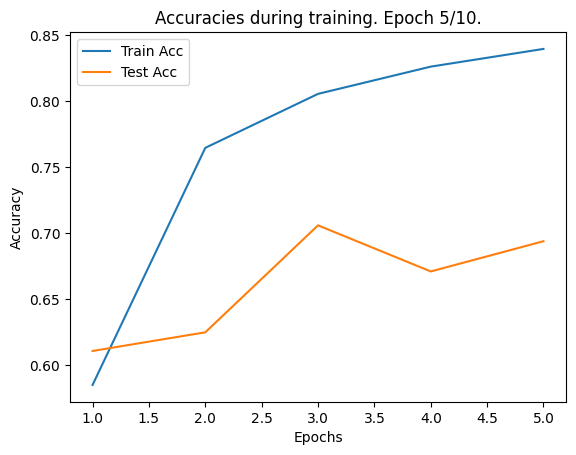

----------
Epoch Time: 5:18
Epoch 6/10
----------
--- Cur phase: train


100%|██████████| 1739/1739 [05:06<00:00,  5.67it/s, Loss=0.434388, Corrects=28/32, Accuracy=87.500%] 


Calculating metrics...
train loss: 0.537773, acc: 0.850255, f05_macro: 0.847600, f1_macro: 0.848273
Confusion matrix:
[[809   1   0 ...   1   1   0]
 [  0 803   0 ...   1   3   0]
 [  0   0 835 ...   1   1   0]
 ...
 [  1   3   1 ... 723   9   0]
 [  0   3   2 ...  14 536   0]
 [  0   0   0 ...   0   0 897]]
--- Cur phase: test


100%|██████████| 193/193 [00:18<00:00, 10.58it/s, Loss=3.610012, Corrects=4/13, Accuracy=30.769%]  


Calculating metrics...
test loss: 0.926424, acc: 0.733799, f05_macro: 0.539848, f1_macro: 0.550825
Confusion matrix:
[[ 11   0   0 ...   0   1   0]
 [  0  52   0 ...   0   0   0]
 [  0   0   1 ...   0   0   0]
 ...
 [  0   0   0 ... 309   3   0]
 [  0   1   0 ...   2  94   0]
 [  0   0   0 ...   0   0   0]]


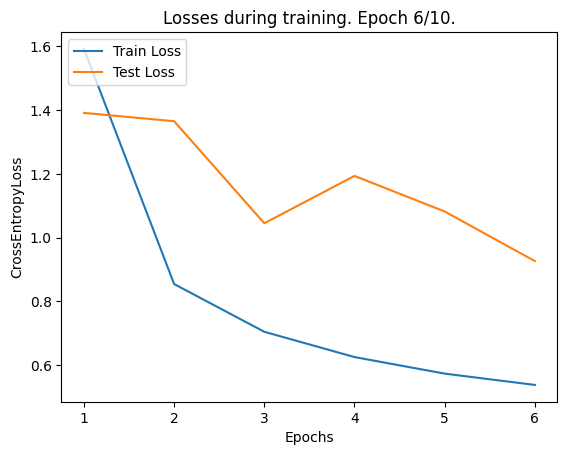

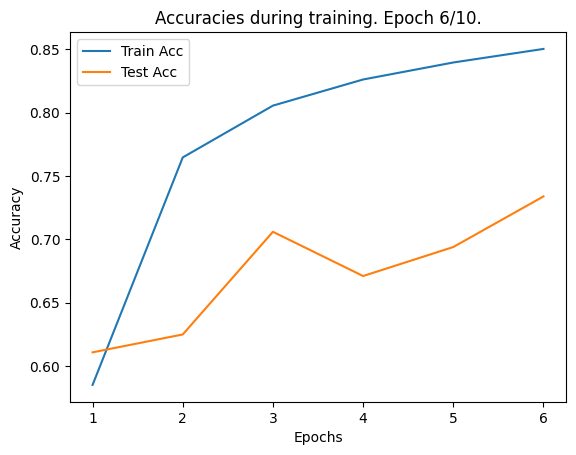

----------
Epoch Time: 5:26
Epoch 7/10
----------
--- Cur phase: train


100%|██████████| 1739/1739 [04:35<00:00,  6.32it/s, Loss=1.190676, Corrects=27/32, Accuracy=84.375%] 


Calculating metrics...
train loss: 0.515232, acc: 0.855574, f05_macro: 0.853239, f1_macro: 0.853820
Confusion matrix:
[[780   4   0 ...   3   0   0]
 [  2 754   0 ...   0   2   0]
 [  0   0 849 ...   2   0   0]
 ...
 [  0   1   1 ... 781  11   0]
 [  0   3   2 ...  10 555   0]
 [  0   0   0 ...   0   0 904]]
--- Cur phase: test


100%|██████████| 193/193 [00:17<00:00, 10.75it/s, Loss=2.493660, Corrects=5/13, Accuracy=38.462%]  


Calculating metrics...
test loss: 0.877697, acc: 0.755238, f05_macro: 0.536762, f1_macro: 0.547753
Confusion matrix:
[[ 11   1   0 ...   0   1   0]
 [  0  52   0 ...   0   0   0]
 [  0   0   1 ...   0   0   0]
 ...
 [  1   0   0 ... 307   3   0]
 [  0   2   0 ...   1  92   0]
 [  0   0   0 ...   0   0   0]]


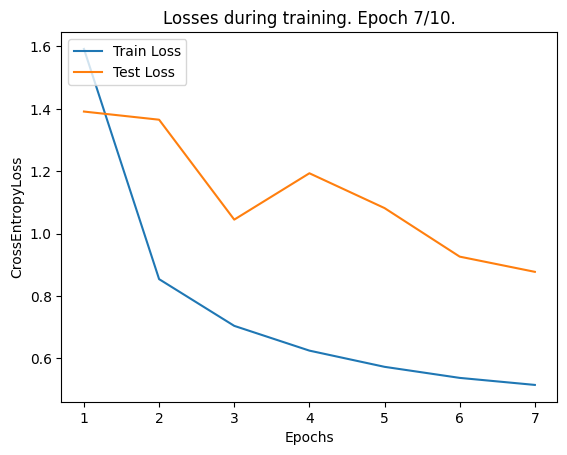

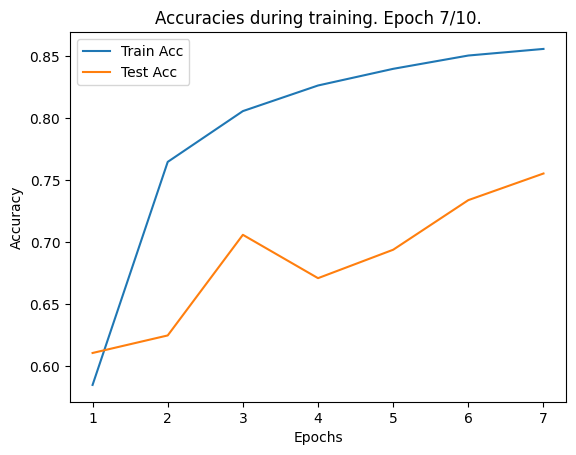

----------
Epoch Time: 4:54
Epoch 8/10
----------
--- Cur phase: train


100%|██████████| 1739/1739 [04:23<00:00,  6.60it/s, Loss=0.573101, Corrects=27/32, Accuracy=84.375%] 


Calculating metrics...
train loss: 0.490805, acc: 0.862008, f05_macro: 0.860588, f1_macro: 0.861110
Confusion matrix:
[[785   2   0 ...   1   0   0]
 [  0 842   0 ...   0   5   0]
 [  0   2 814 ...   0   1   0]
 ...
 [  0   5   0 ... 672   8   0]
 [  0   4   1 ...   6 607   0]
 [  0   0   0 ...   0   0 916]]
--- Cur phase: test


100%|██████████| 193/193 [00:18<00:00, 10.71it/s, Loss=1.171731, Corrects=7/13, Accuracy=53.846%]  


Calculating metrics...
test loss: 0.928507, acc: 0.743706, f05_macro: 0.524573, f1_macro: 0.537126
Confusion matrix:
[[  8   1   0 ...   0   1   0]
 [  0  52   0 ...   0   0   0]
 [  0   0   1 ...   1   0   0]
 ...
 [  0   0   1 ... 321   2   0]
 [  0   2   0 ...   1  94   0]
 [  0   0   0 ...   0   0   0]]


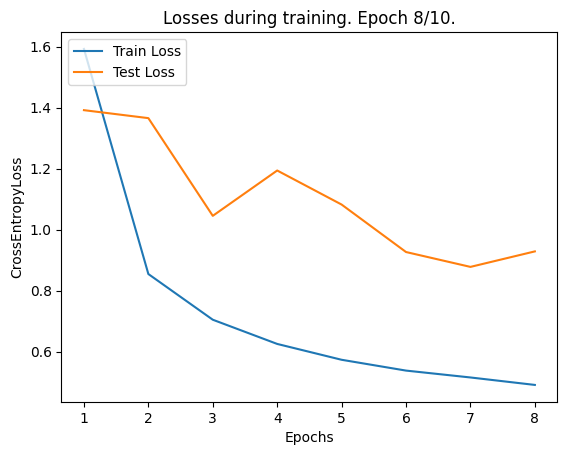

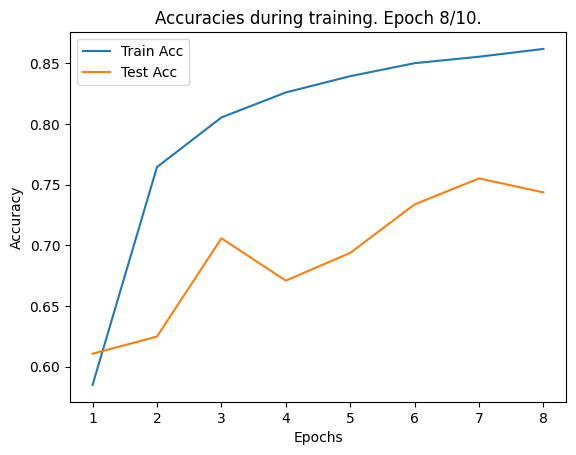

----------
Epoch Time: 4:42
Epoch 9/10
----------
--- Cur phase: train


100%|██████████| 1739/1739 [04:31<00:00,  6.40it/s, Loss=0.315733, Corrects=30/32, Accuracy=93.750%] 


Calculating metrics...
train loss: 0.469690, acc: 0.868351, f05_macro: 0.866783, f1_macro: 0.867239
Confusion matrix:
[[807   1   0 ...   3   0   0]
 [  6 801   0 ...   1   2   0]
 [  0   0 845 ...   1   0   0]
 ...
 [  2   0   1 ... 665  15   0]
 [  0   2   0 ...  18 612   0]
 [  0   0   0 ...   0   0 864]]
--- Cur phase: test


100%|██████████| 193/193 [00:17<00:00, 10.75it/s, Loss=1.412505, Corrects=9/13, Accuracy=69.231%]  


Calculating metrics...
test loss: 0.793955, acc: 0.783336, f05_macro: 0.558372, f1_macro: 0.580271
Confusion matrix:
[[ 10   1   0 ...   0   1   0]
 [  0  52   0 ...   0   0   0]
 [  0   0   1 ...   1   0   0]
 ...
 [  0   0   0 ... 303   2   0]
 [  0   1   0 ...   0  88   0]
 [  0   0   0 ...   0   0   0]]


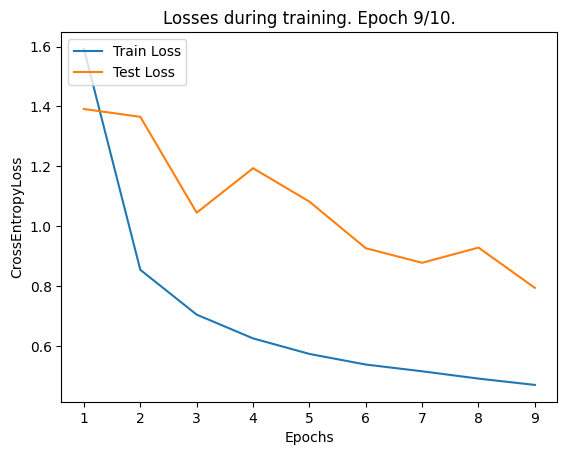

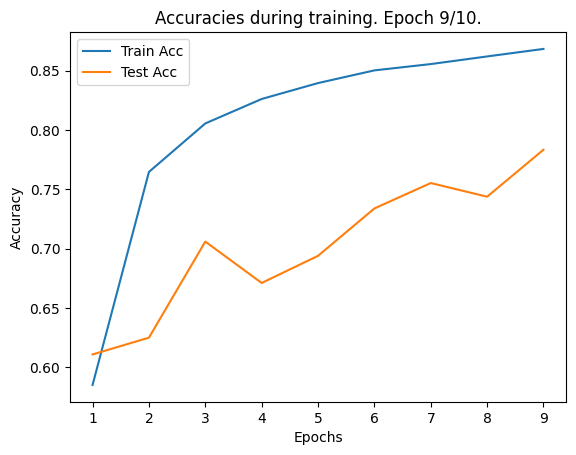

----------
Epoch Time: 4:50
Epoch 10/10
----------
--- Cur phase: train


100%|██████████| 1739/1739 [04:32<00:00,  6.38it/s, Loss=0.091604, Corrects=32/32, Accuracy=100.000%]


Calculating metrics...
train loss: 0.458708, acc: 0.870831, f05_macro: 0.868526, f1_macro: 0.868950
Confusion matrix:
[[855   2   0 ...   0   0   0]
 [  5 755   0 ...   0   7   0]
 [  0   0 868 ...   0   2   0]
 ...
 [  3   0   0 ... 730  15   0]
 [  0   8   3 ...  11 569   0]
 [  0   0   0 ...   0   0 935]]
--- Cur phase: test


100%|██████████| 193/193 [00:17<00:00, 10.73it/s, Loss=2.039706, Corrects=6/13, Accuracy=46.154%]  


Calculating metrics...
test loss: 0.858075, acc: 0.758161, f05_macro: 0.502730, f1_macro: 0.522322
Confusion matrix:
[[ 11   1   0 ...   0   1   0]
 [  0  51   0 ...   0   0   0]
 [  0   0   1 ...   0   1   0]
 ...
 [  0   0   0 ... 319   2   0]
 [  0   1   0 ...   1 101   0]
 [  0   0   0 ...   0   0   0]]


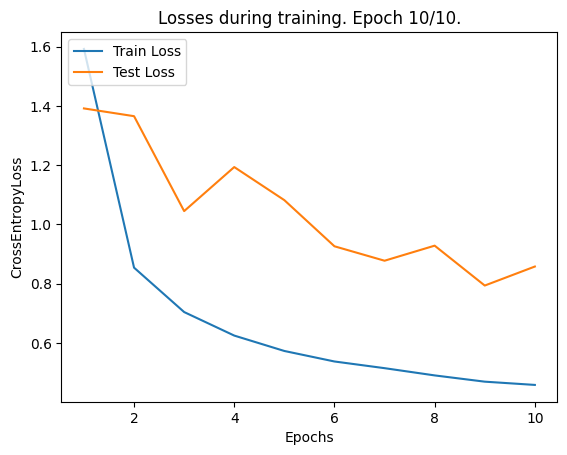

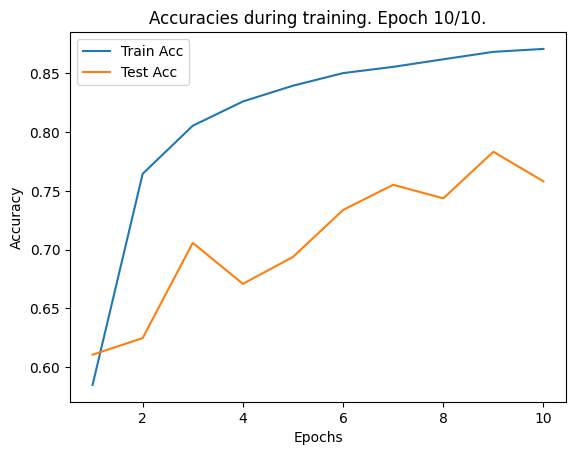

----------
Epoch Time: 4:51
*** Training Completed ***


({'train': [1.5922134388034683,
   0.8543113080882149,
   0.7045229855772749,
   0.6251710202714161,
   0.5732281909266925,
   0.5377731671885658,
   0.5152322883145212,
   0.49080539668699735,
   0.4696901060989991,
   0.4587075836504496],
  'test': [1.3914571517044718,
   1.3653237710085049,
   1.0450739141638952,
   1.19366948580769,
   1.0820332681743554,
   0.926424324173654,
   0.8776974835255635,
   0.9285065086123733,
   0.7939550950094654,
   0.8580748307660394]},
 {'train': [0.5849626221966647,
   0.7645917193789534,
   0.8054916618746406,
   0.8261213341000575,
   0.8395449971247844,
   0.8502551753881541,
   0.8555743243243243,
   0.8620076193214491,
   0.8683510638297872,
   0.870830937320299],
  'test': [0.6106870229007634,
   0.624817281143414,
   0.705863245086893,
   0.6709436413837908,
   0.6938444047425695,
   0.7337989280493747,
   0.7552379405554653,
   0.7437063504953711,
   0.7833360402793569,
   0.7581614422608414]},
 {'train': [0.5687666728890214,
   0.75884269

In [44]:
dataloaders = dict()
dataloaders['train'] = DataLoader(image_datasets['train'],
                                  sampler=ImbalancedDatasetSampler(image_datasets['train']),
                                  batch_size=batch_size,
                                  num_workers=num_workers,
                                  pin_memory=True,
                                  drop_last=True,
                                  worker_init_fn=seed_worker,
                                  generator=g)
dataloaders['test'] = DataLoader(image_datasets['test'],
                                 batch_size=batch_size,
                                 shuffle=False,
                                 num_workers=num_workers,
                                 pin_memory=True,
                                 worker_init_fn=seed_worker,
                                 generator=g)

train_model(dataloaders, 10)

# Saving and loading trained weights for pretrained ResNet model on ImageNet

In [45]:
pretrained_resnet50_ckpt_path = 'my_trained_pretrained_resnet50_with_sampler.pth'
torch.save(model.state_dict(), pretrained_resnet50_ckpt_path)

In [42]:
model = get_my_resnet_50(num_classes=num_classes)
model.load_state_dict(torch.load(pretrained_resnet50_ckpt_path, map_location=torch.device('cpu')))

/tmp/ipykernel_30/3979360900.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(pretrained_resnet50_ckpt_path, map_location=torch.device('c

<All keys matched successfully>

# Conslusion:
- тренируется быстрее, поскольку не нужно считать градиенты для convolution слоя
- высокий скор в начале стадии тренировки
- хуже сходимость у предобученной модели